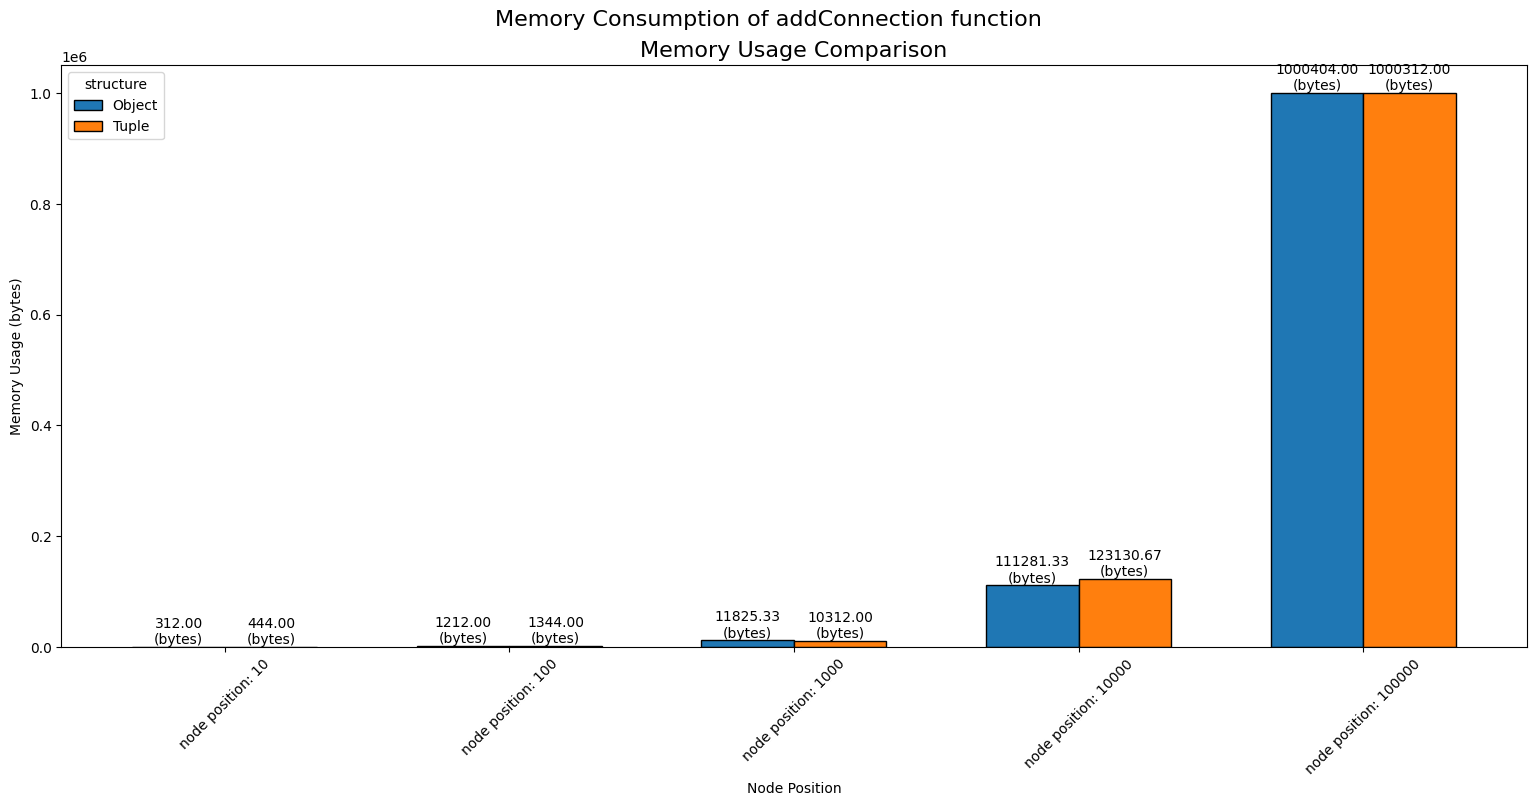

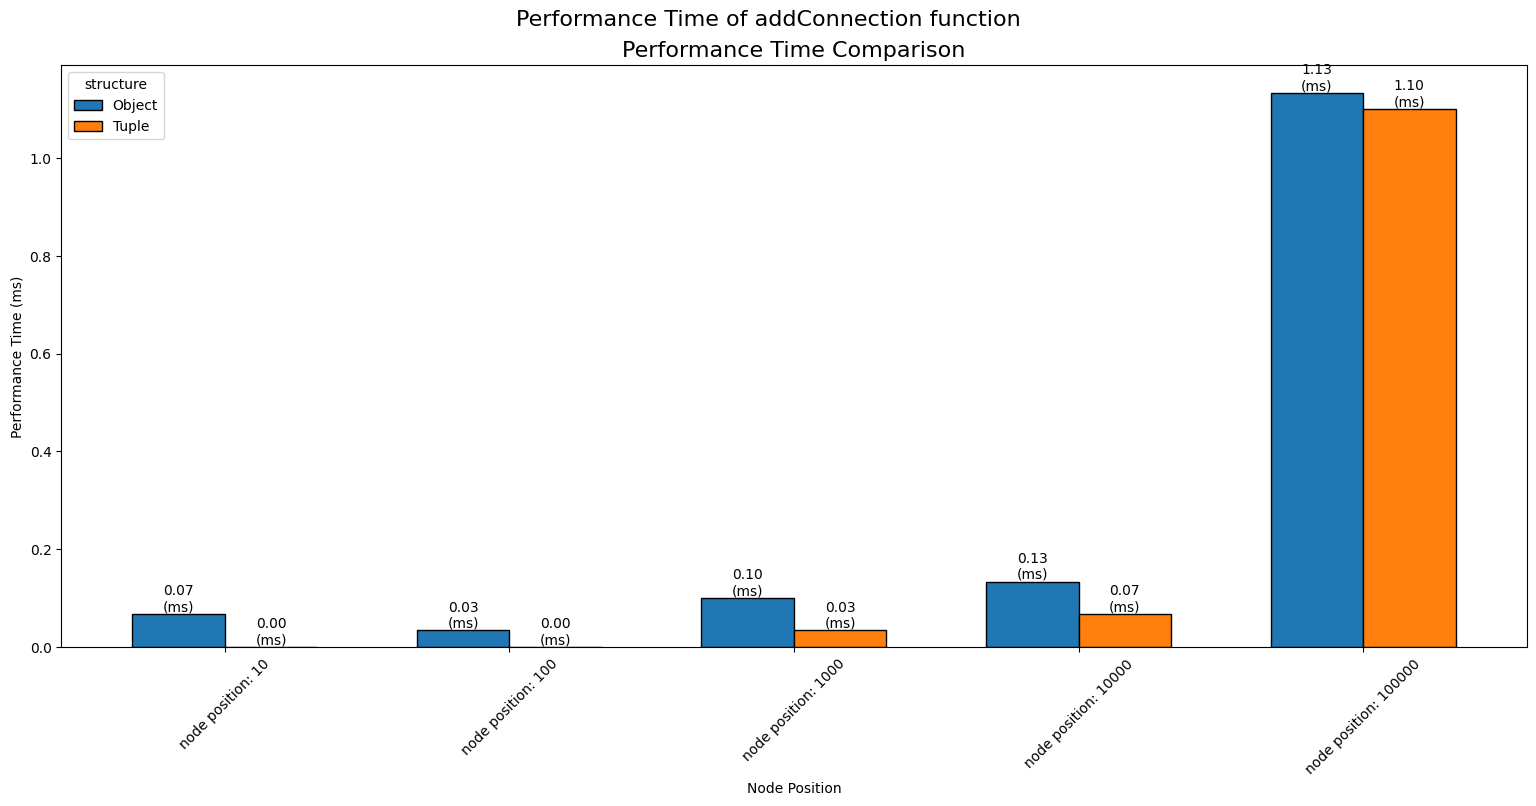

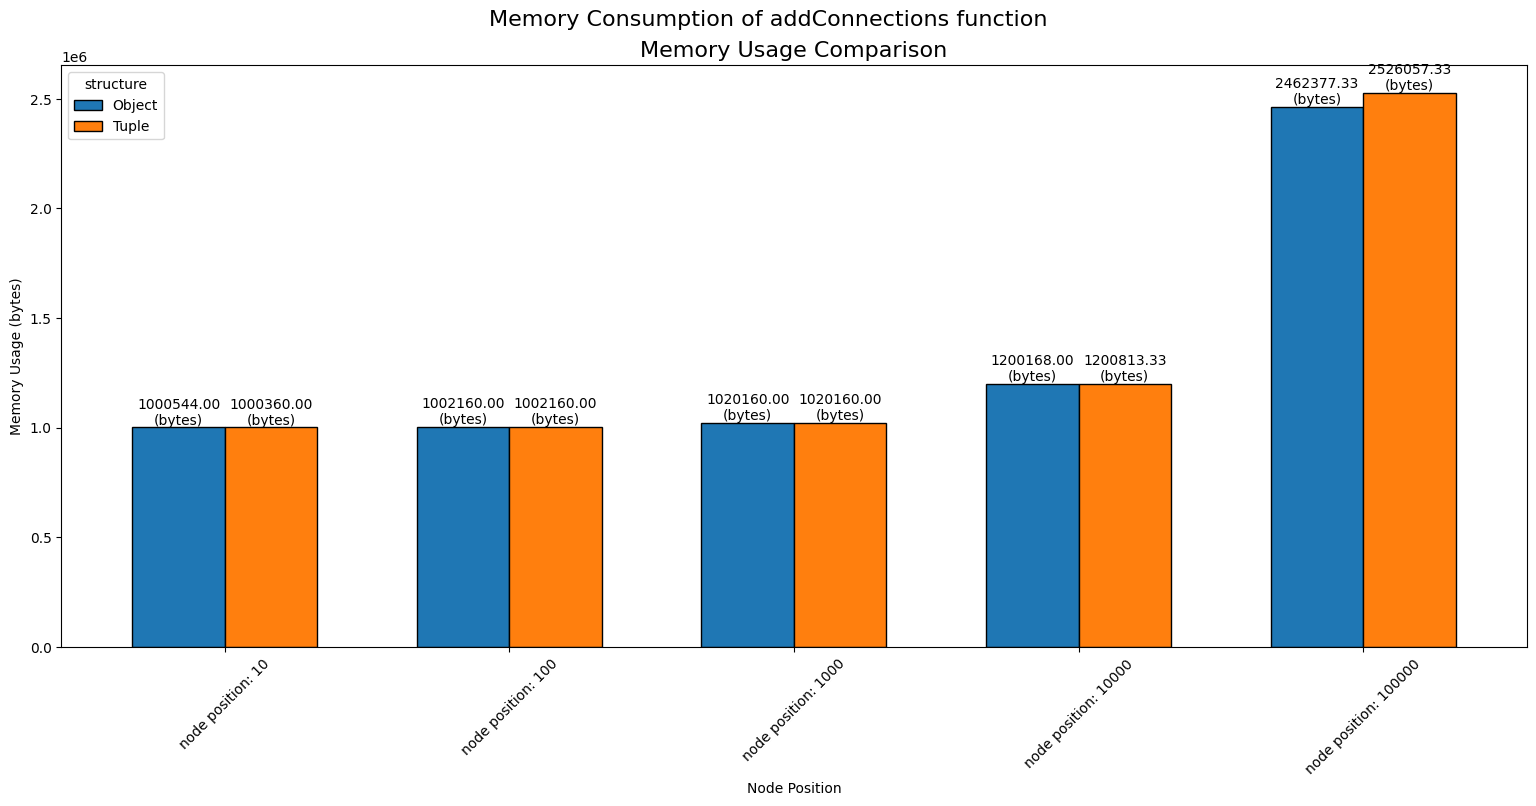

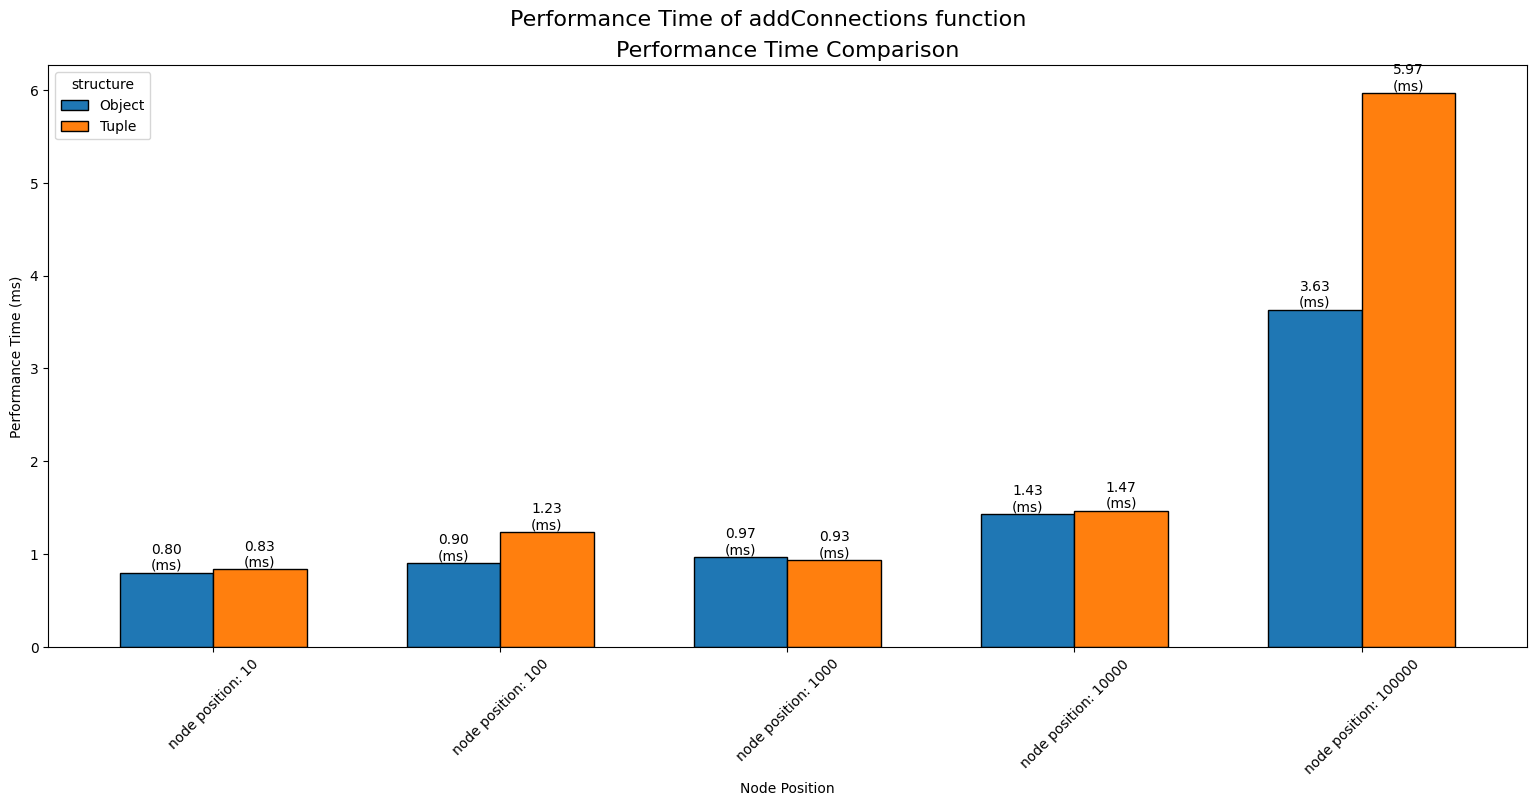

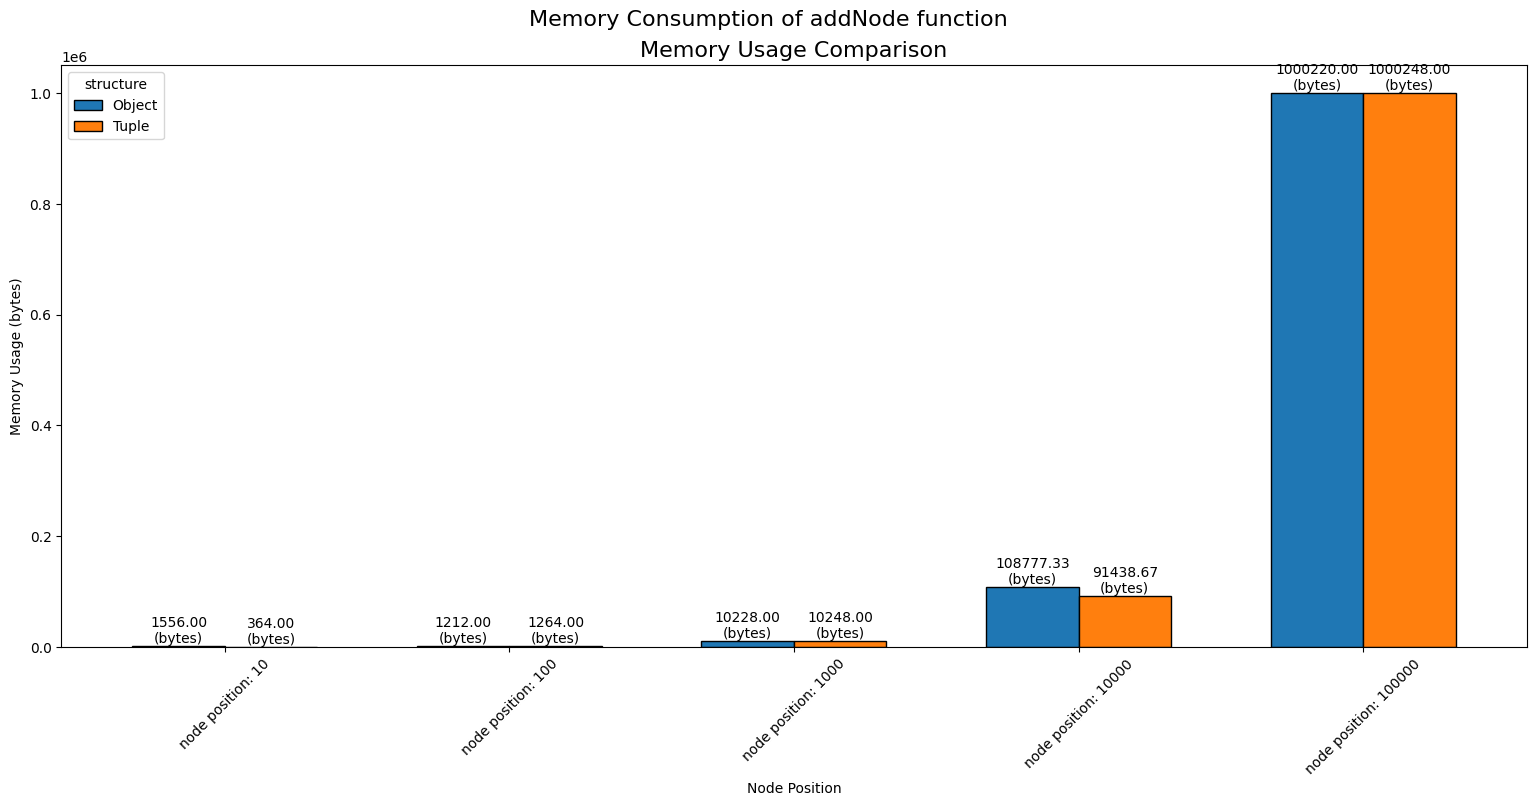

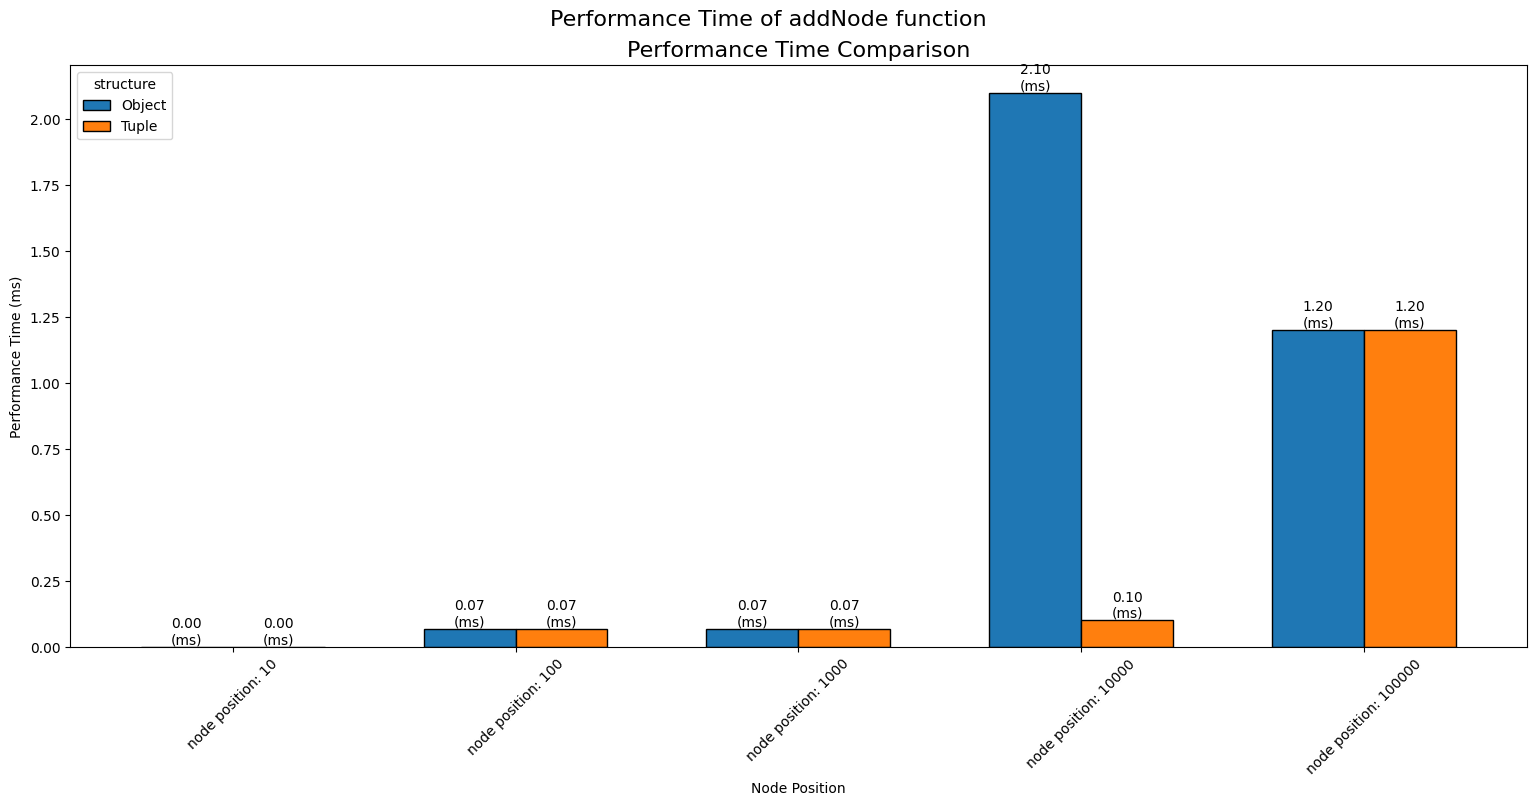

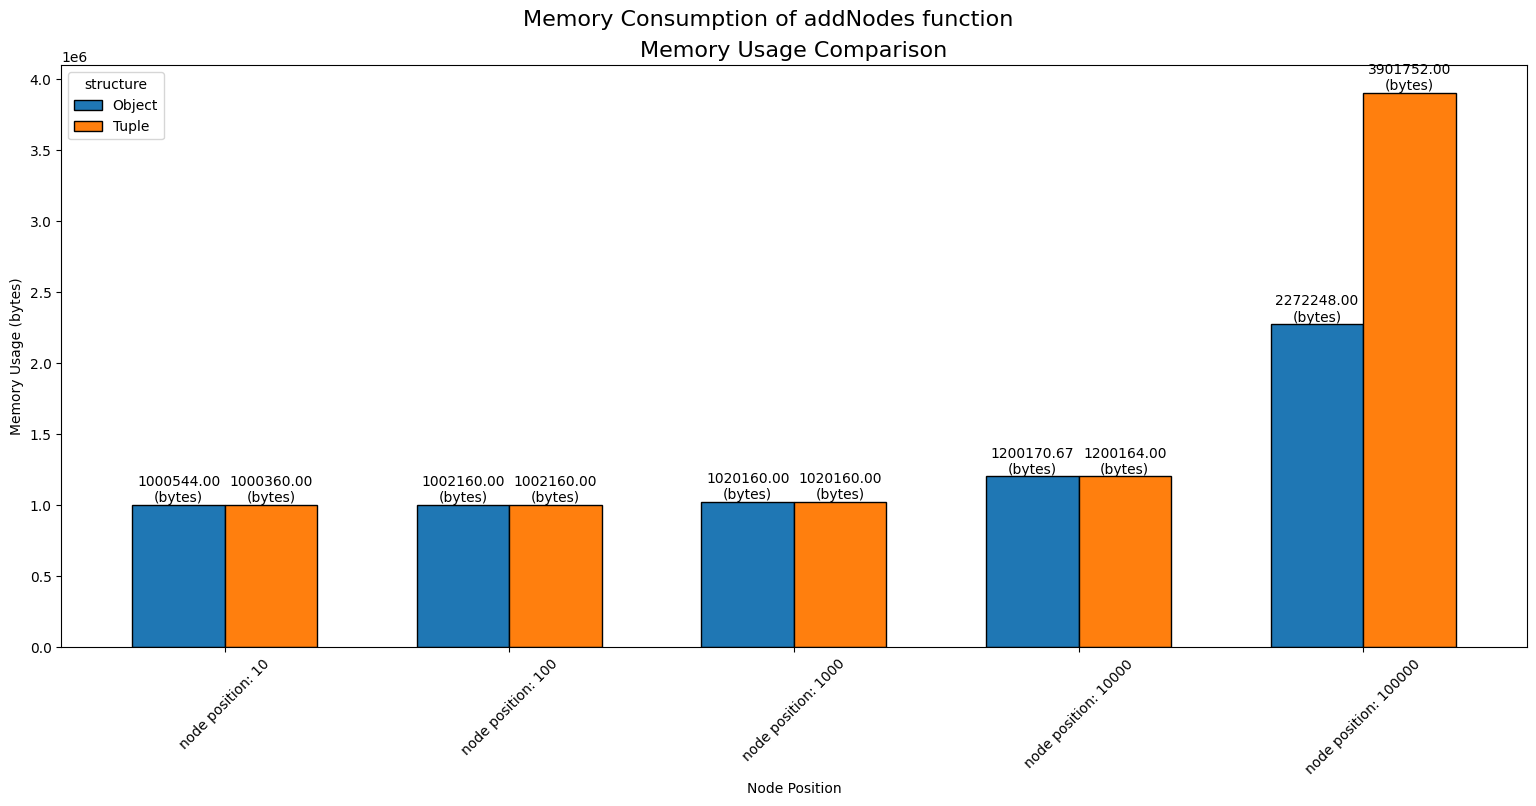

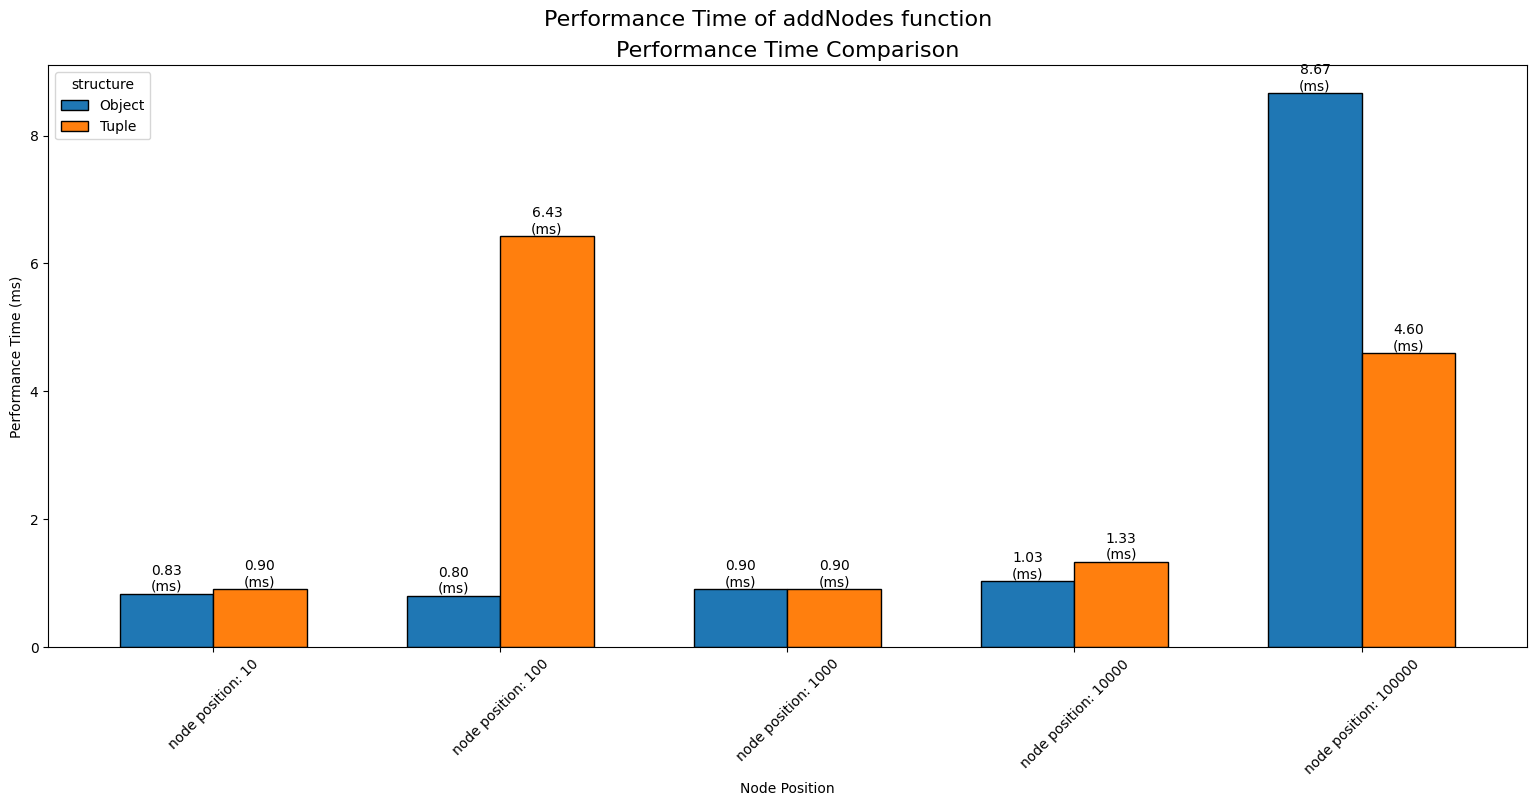

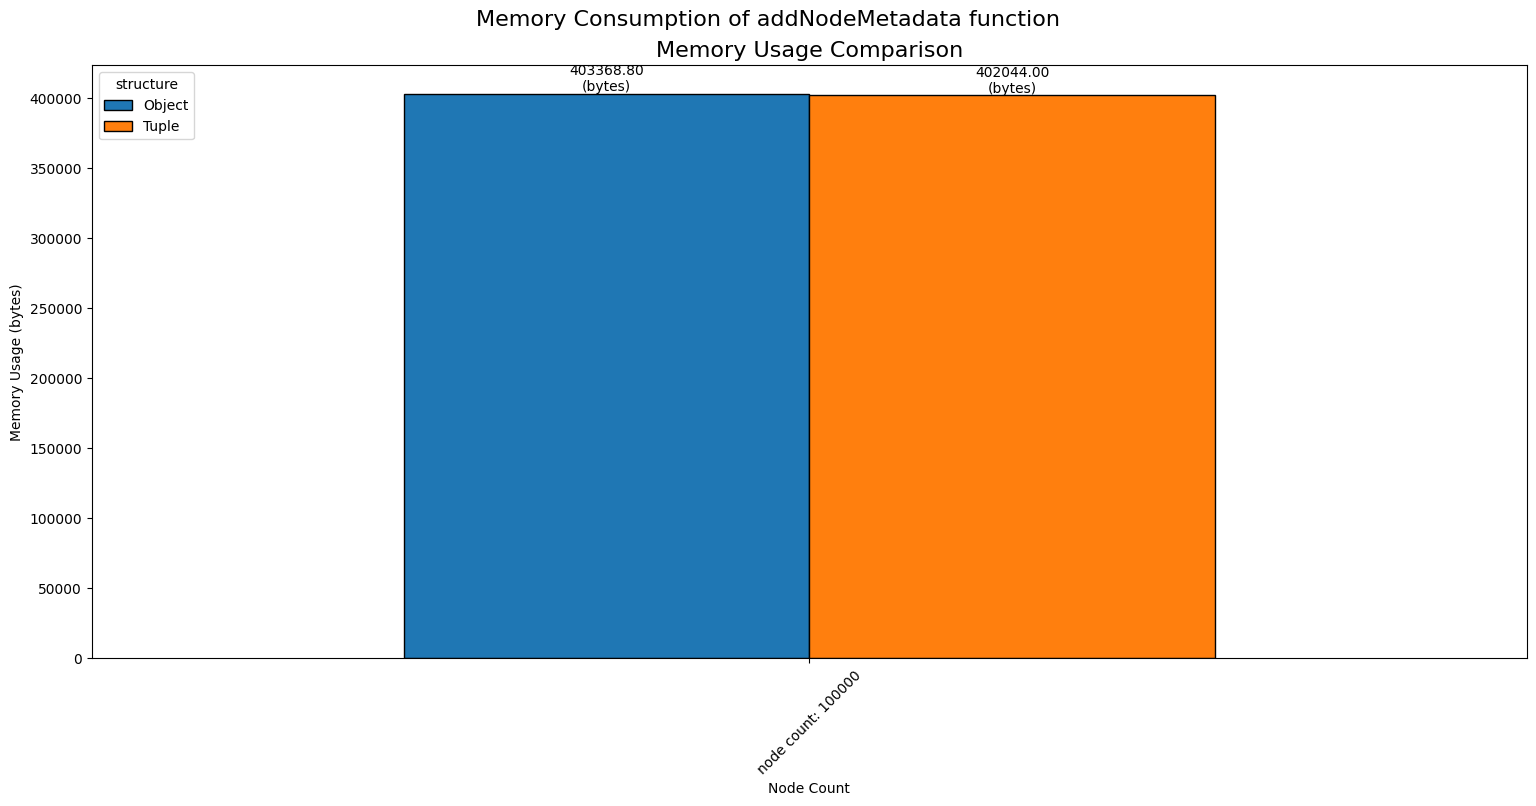

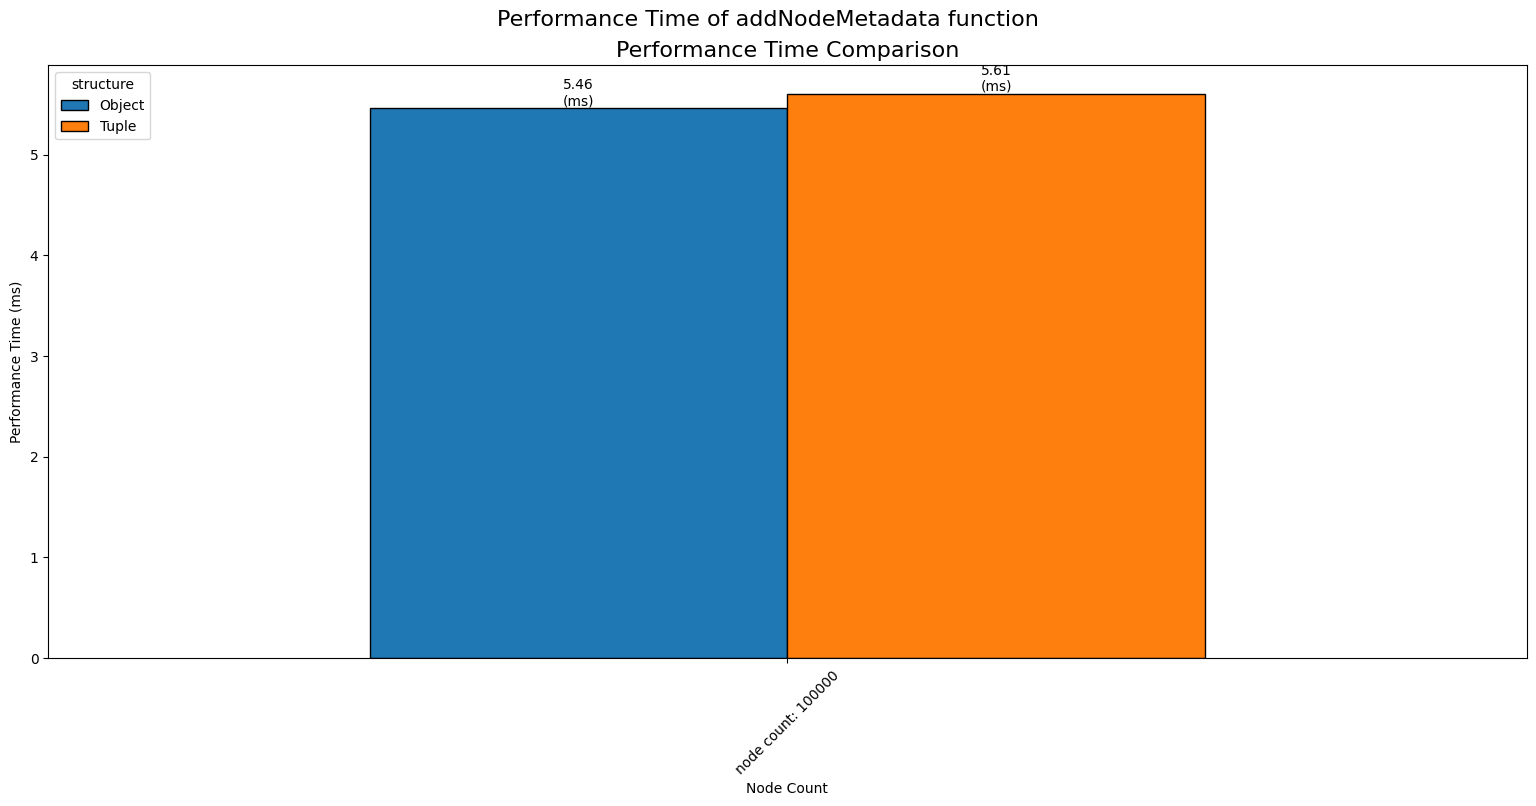

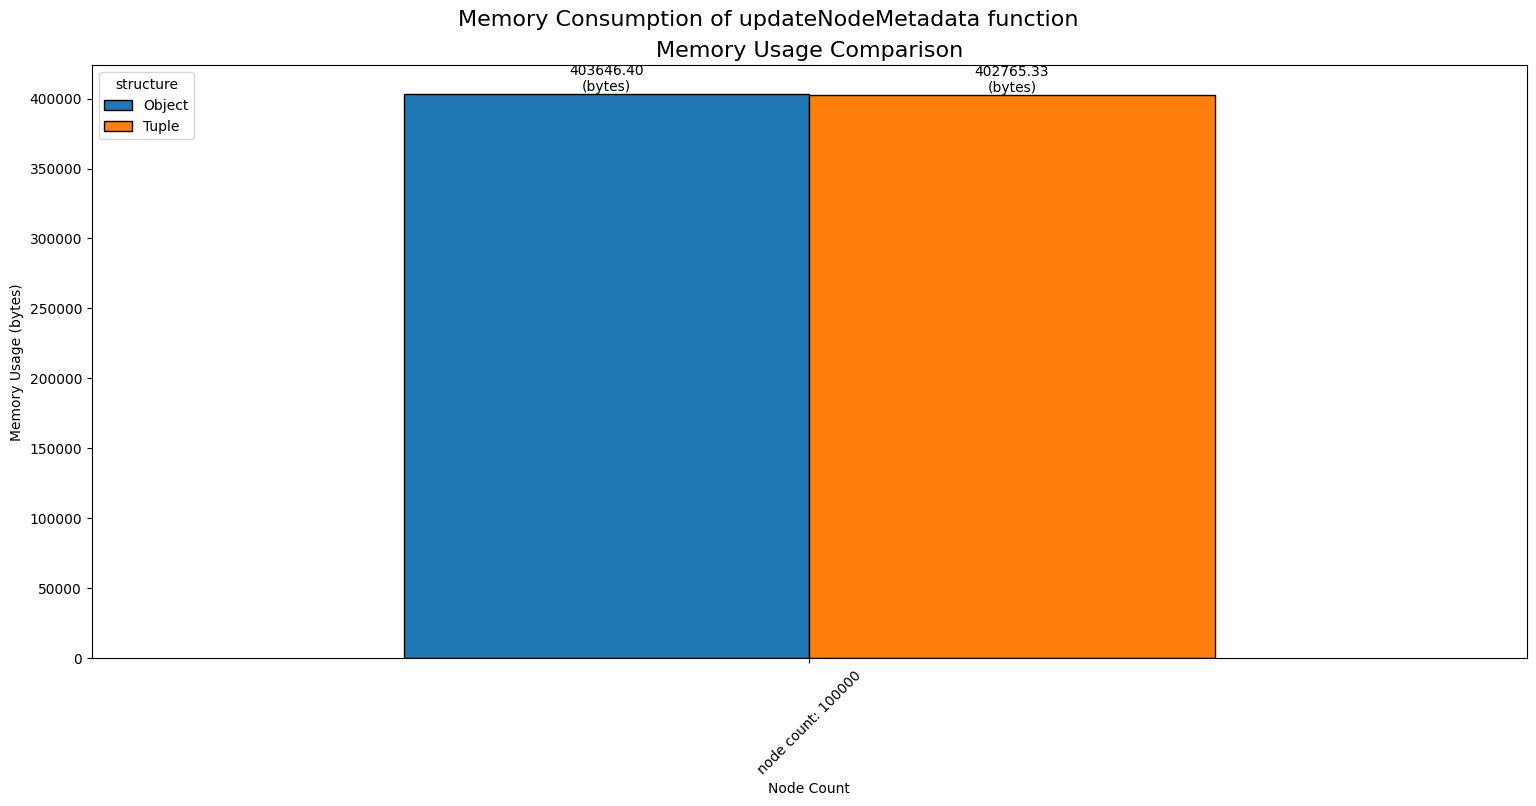

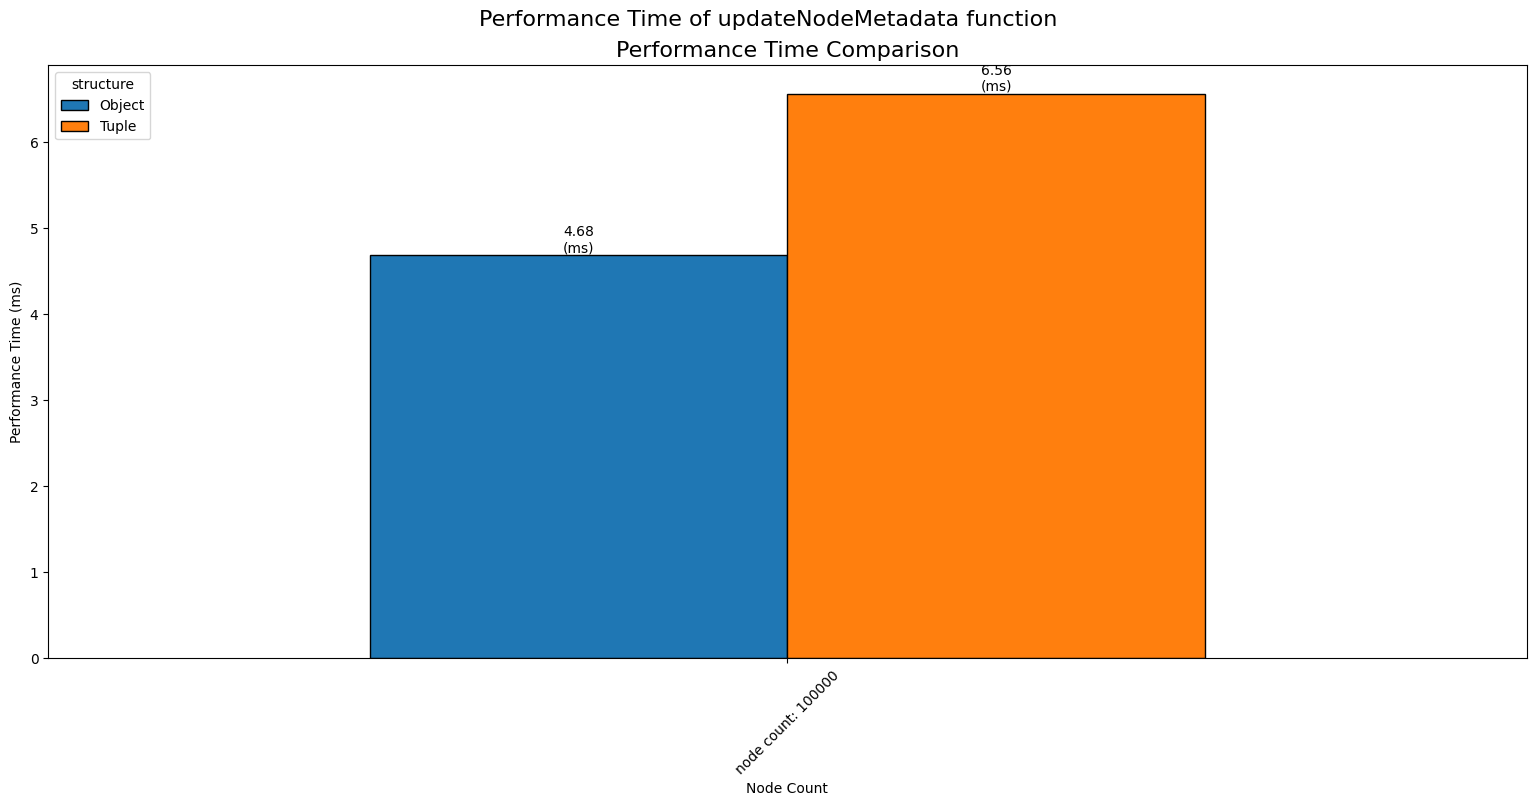

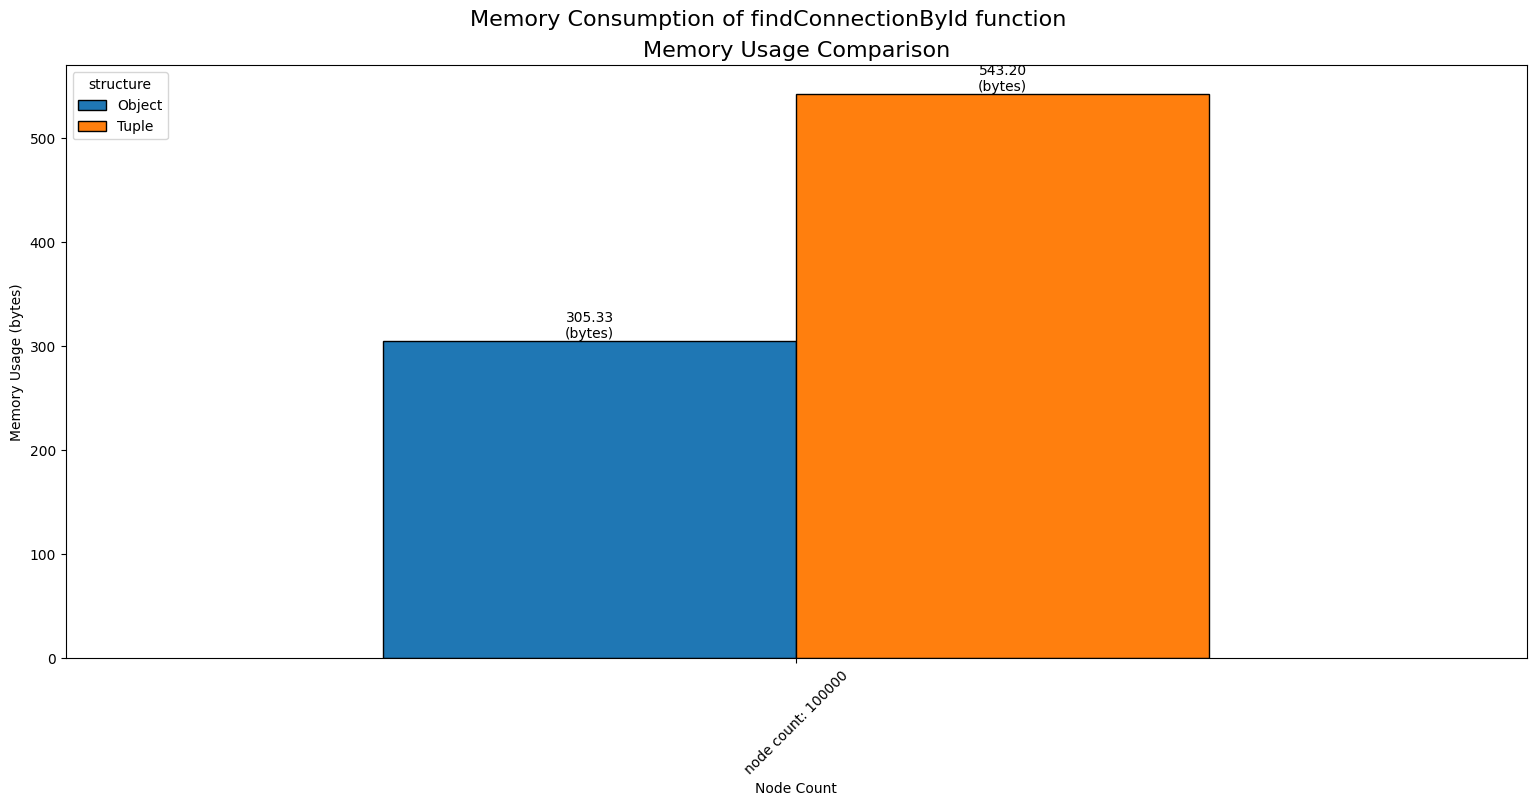

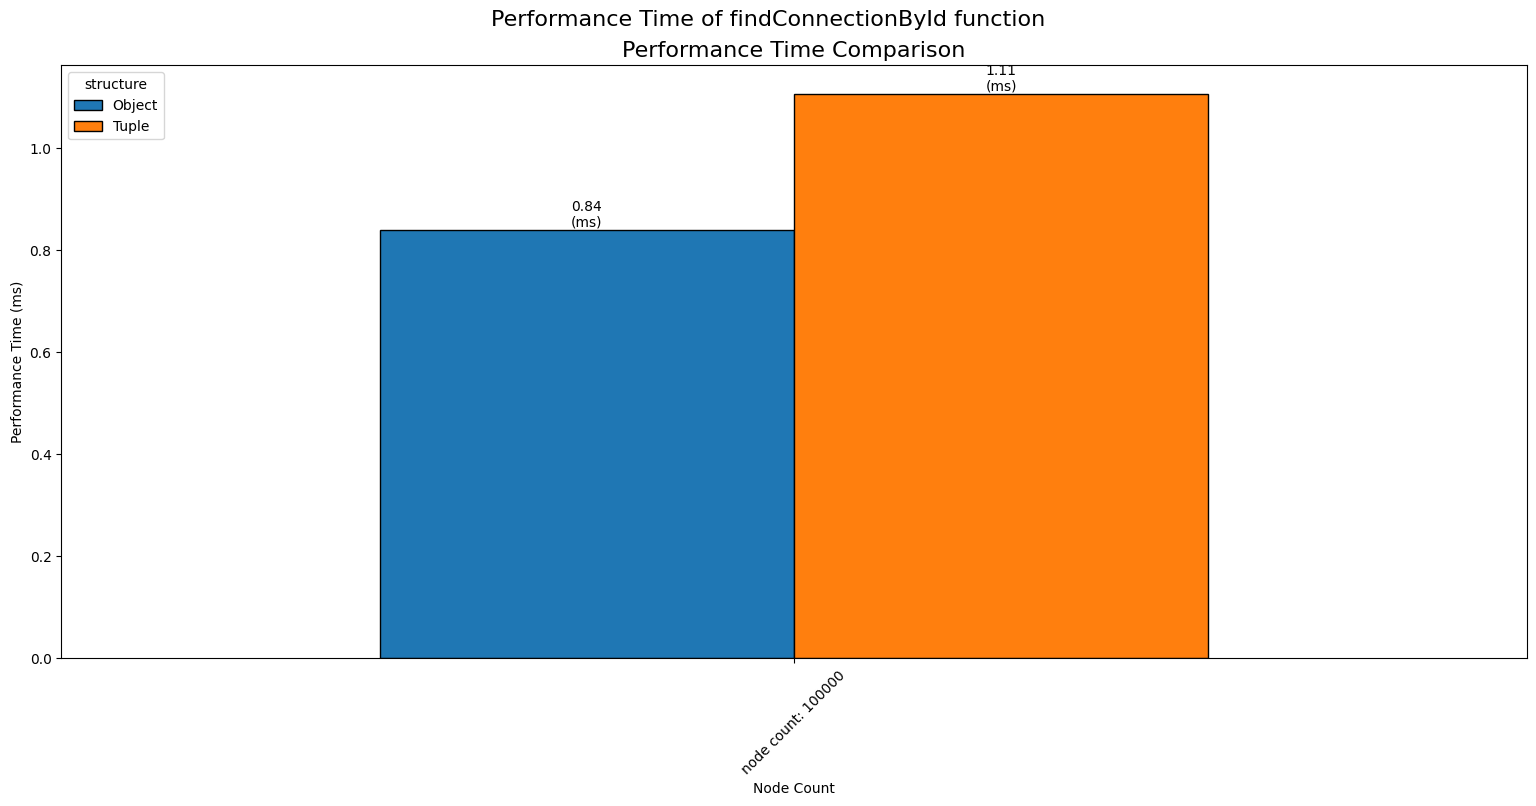

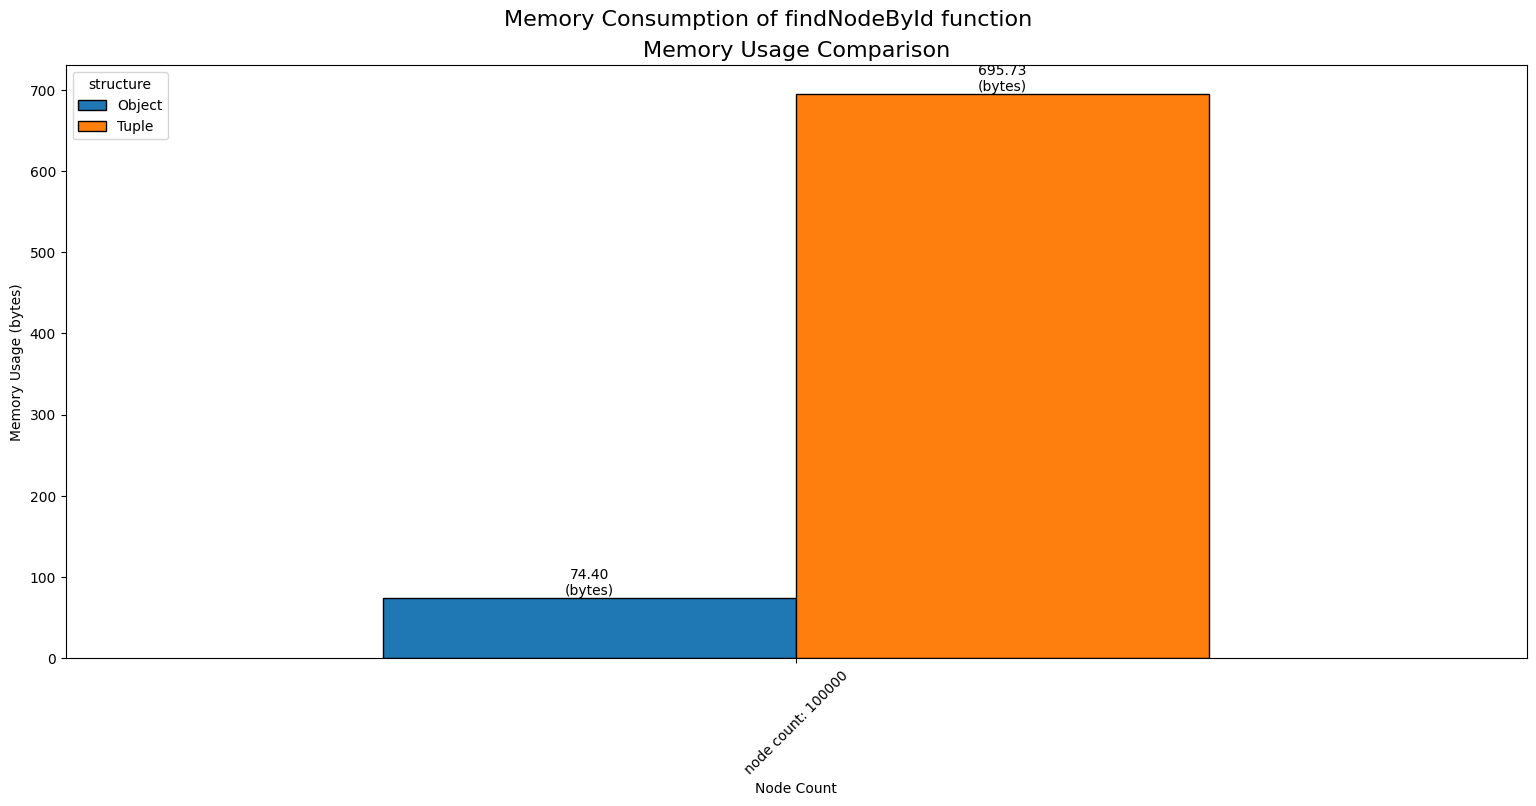

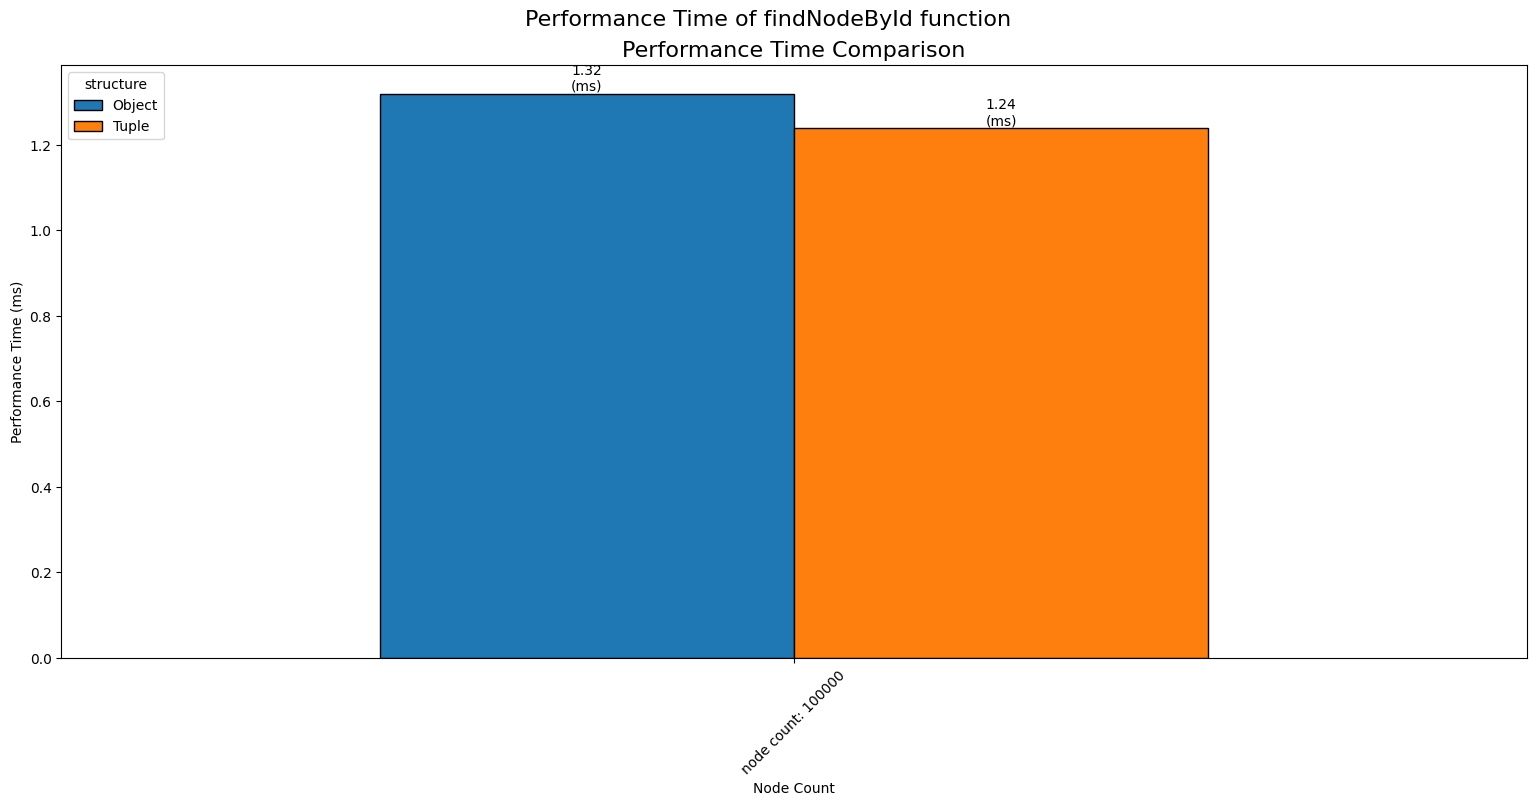

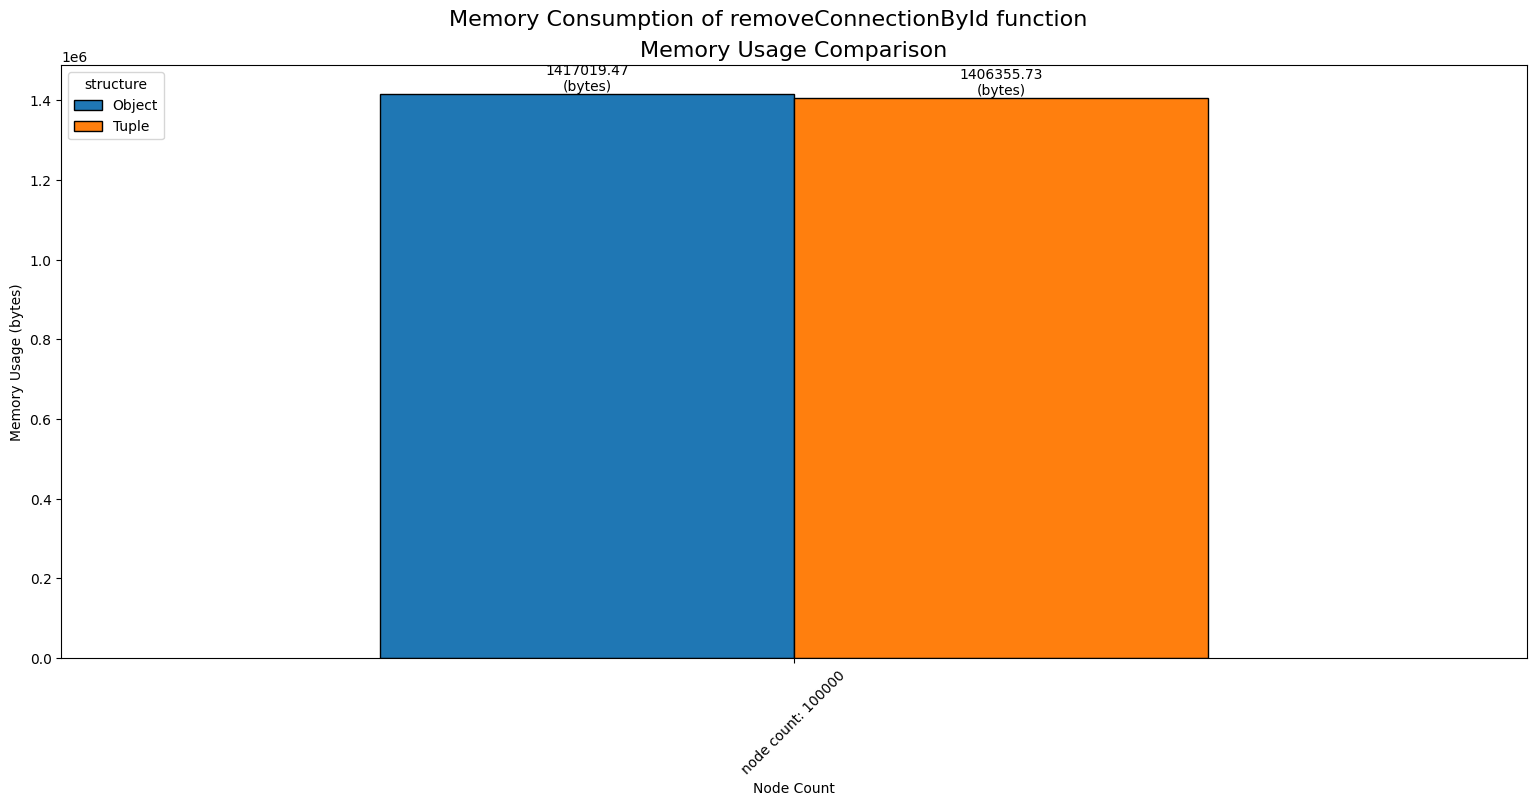

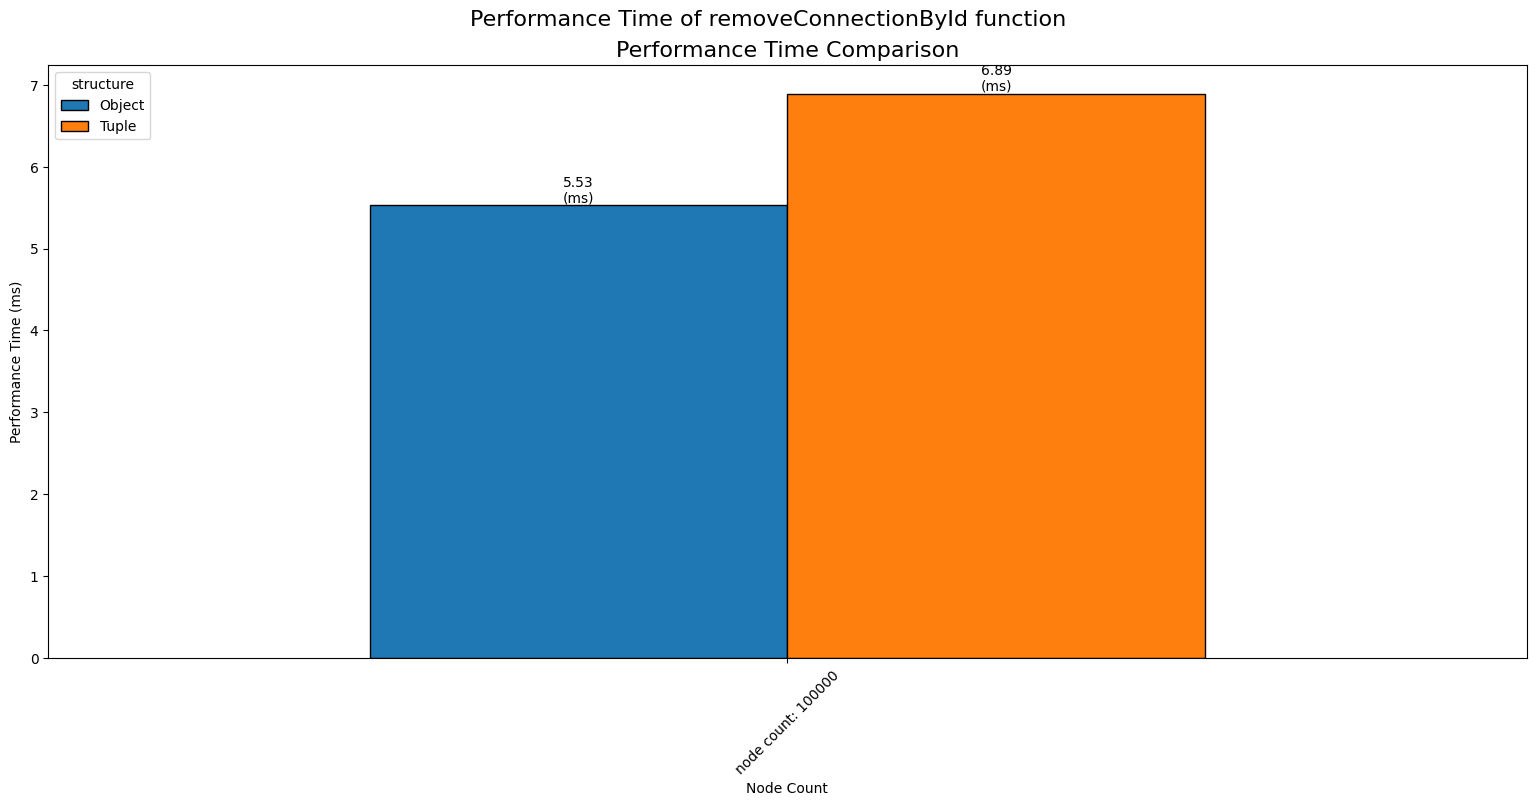

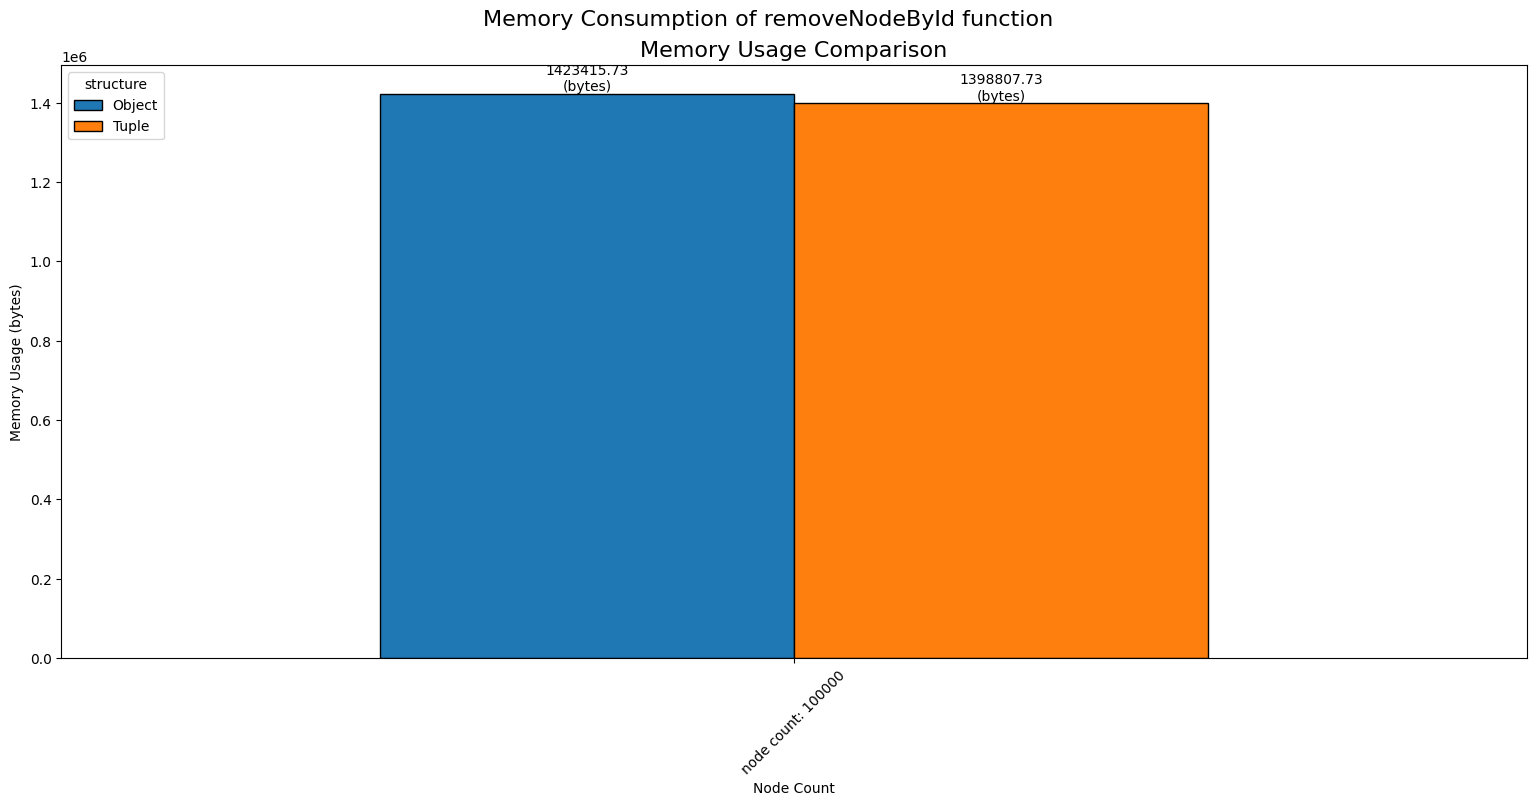

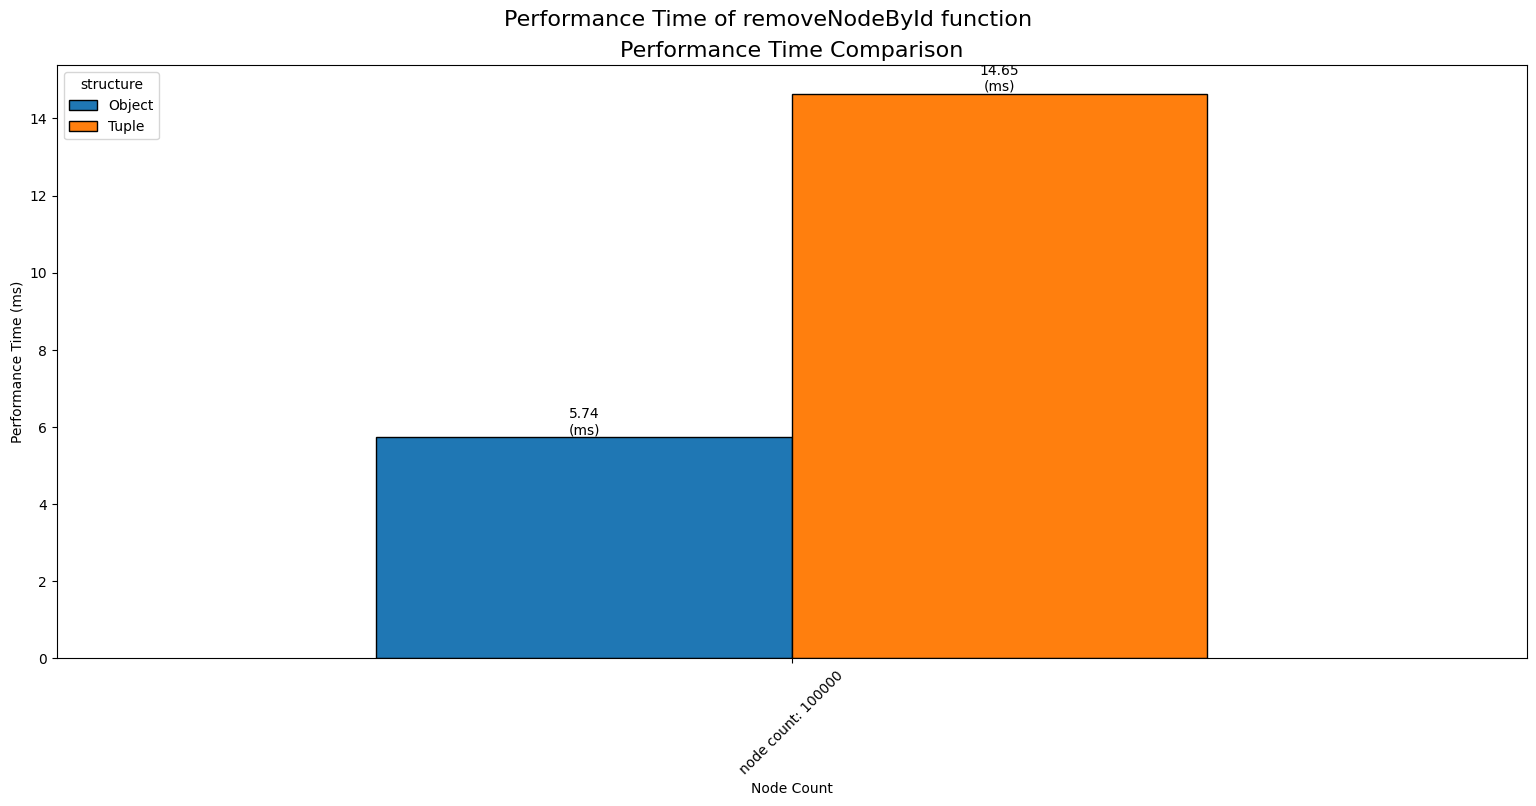

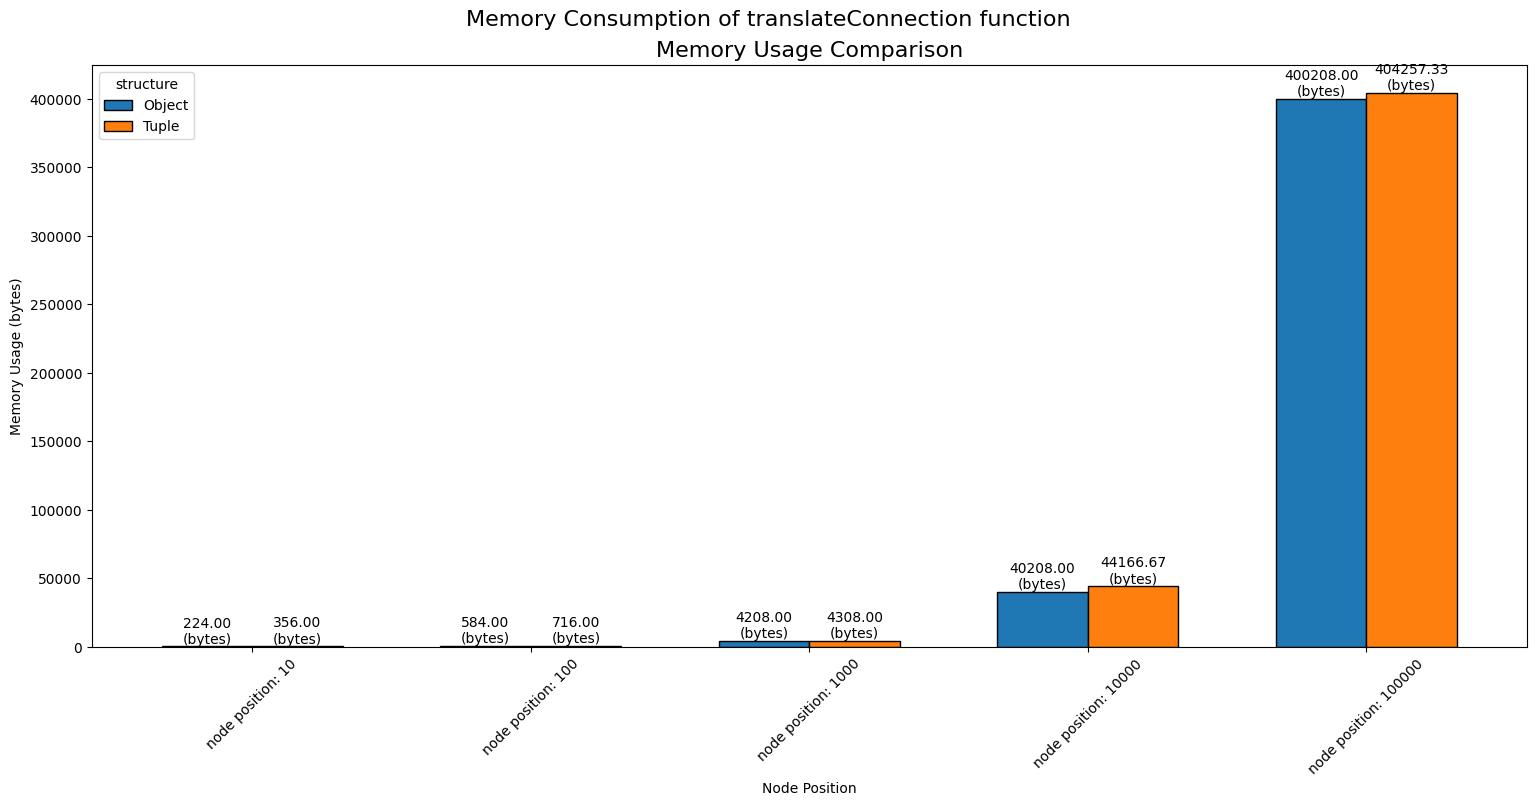

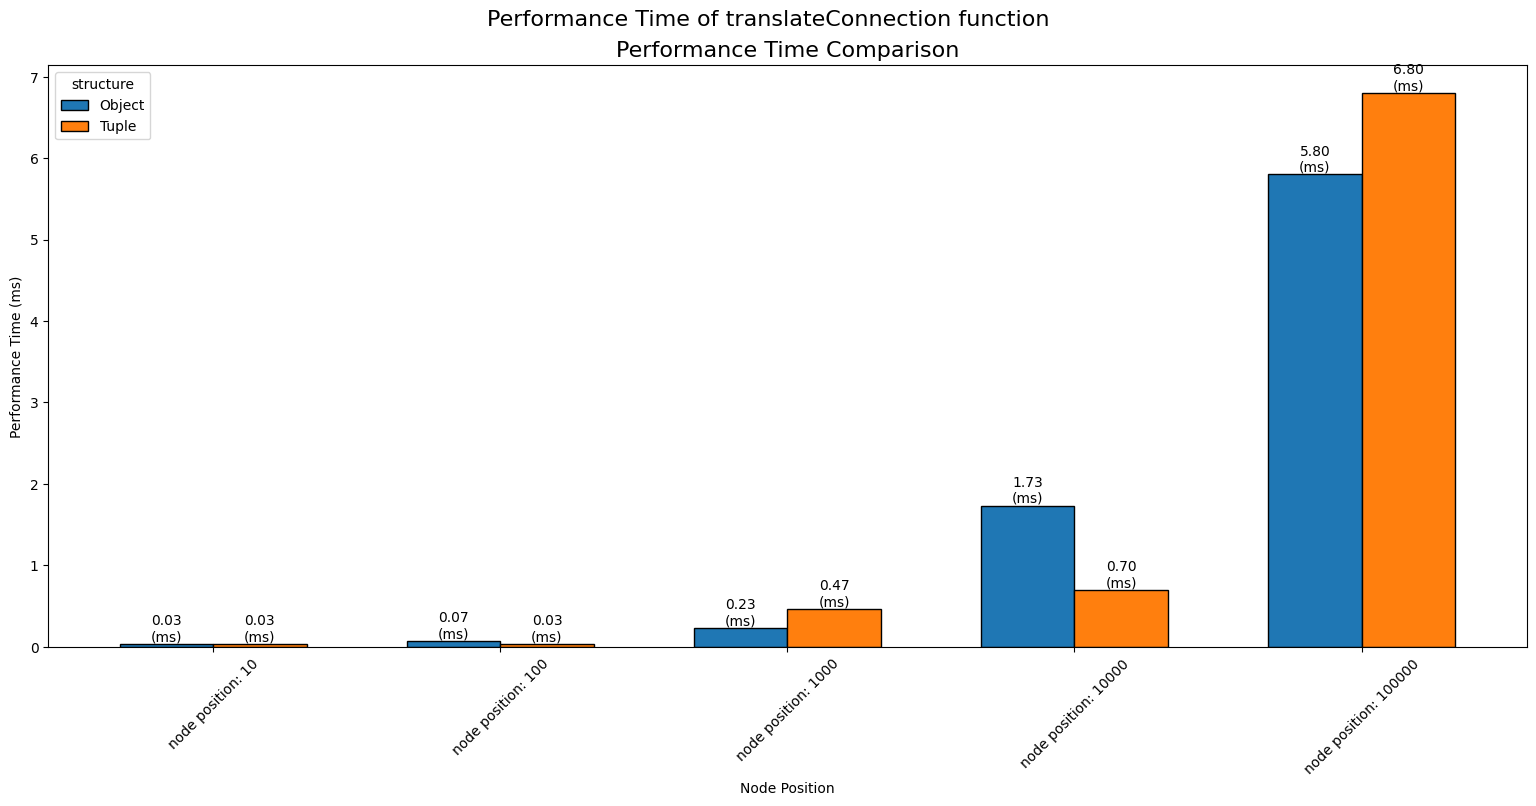

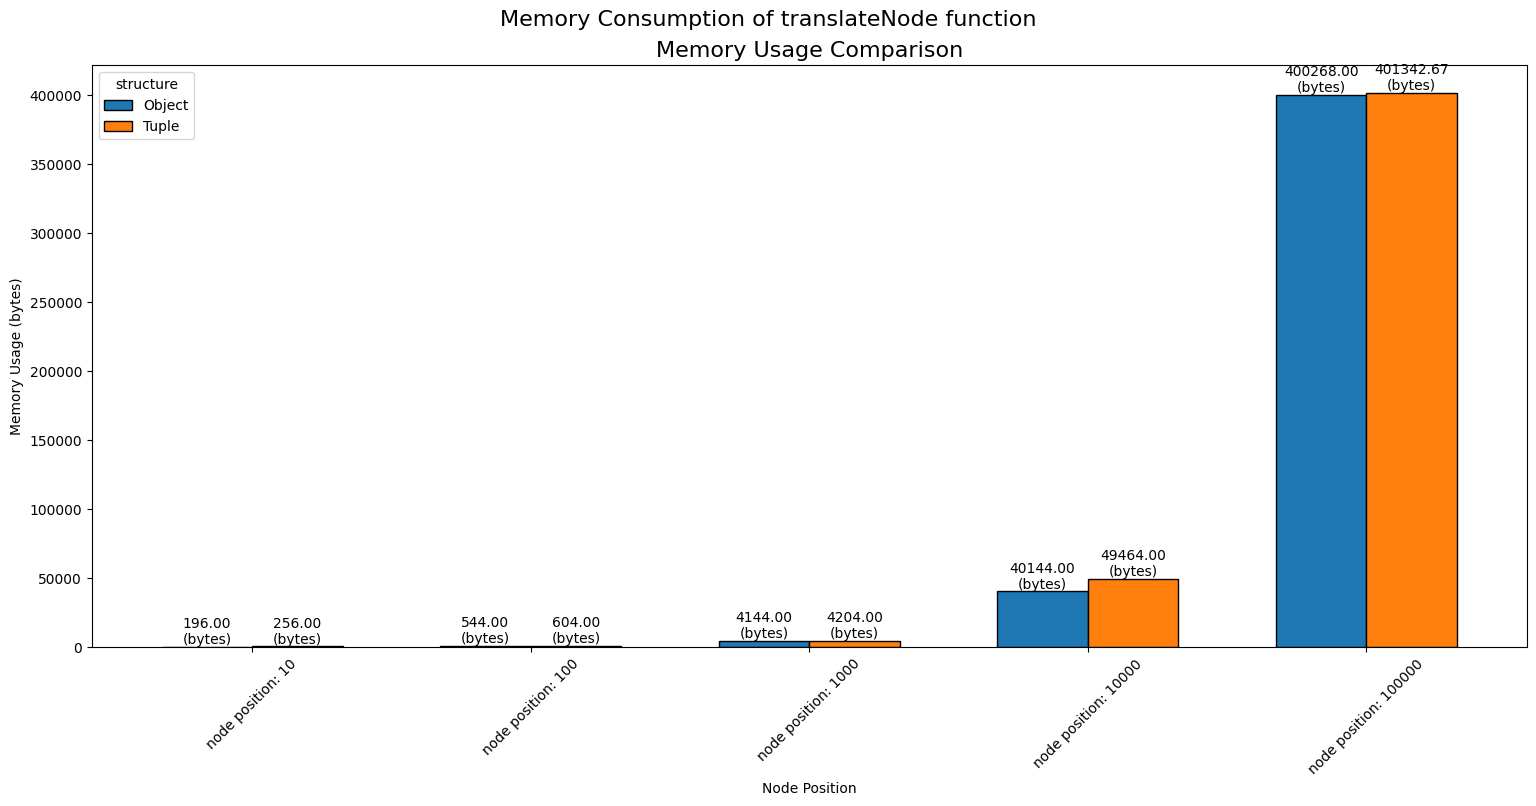

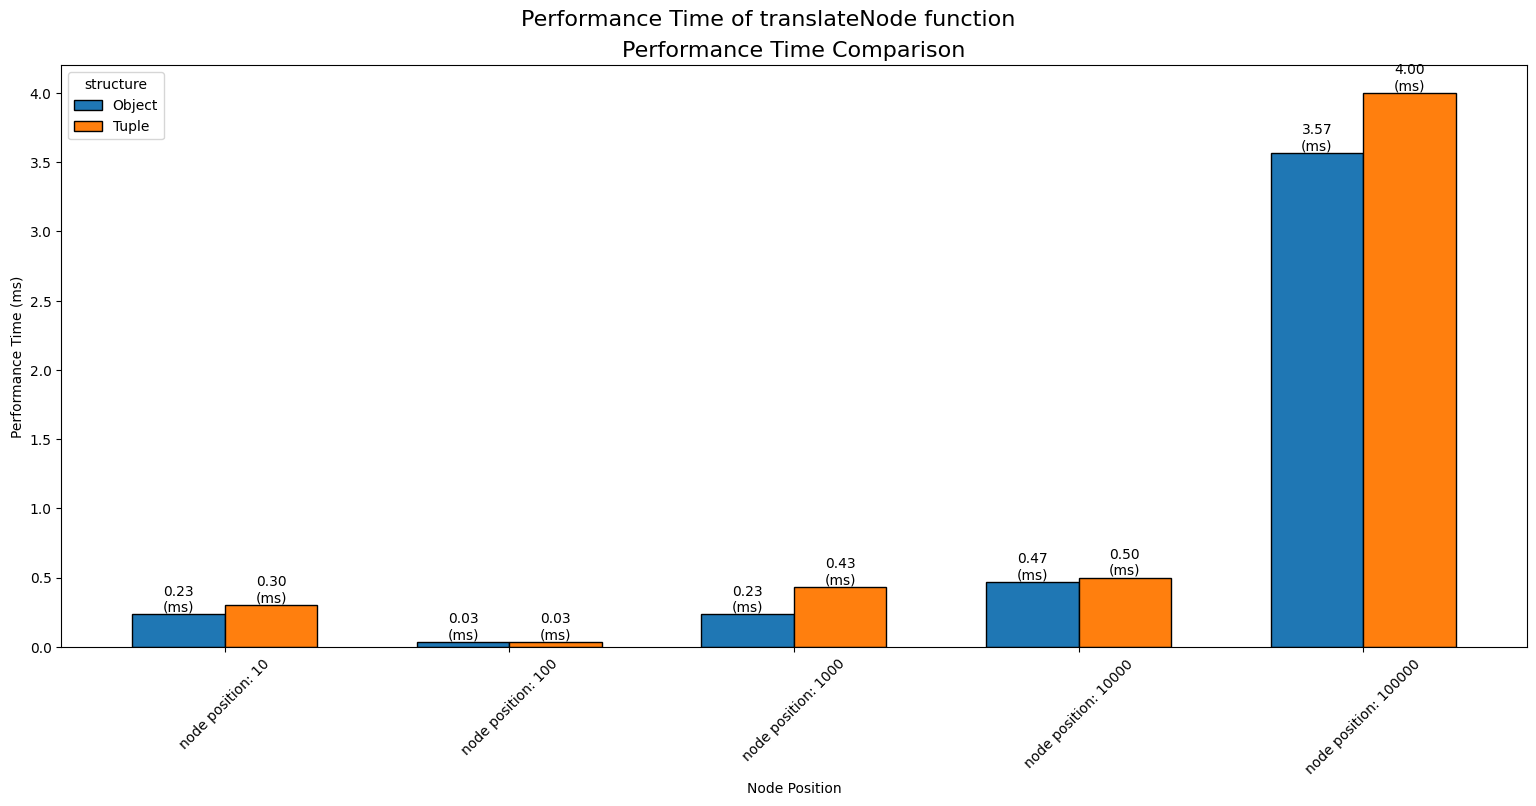

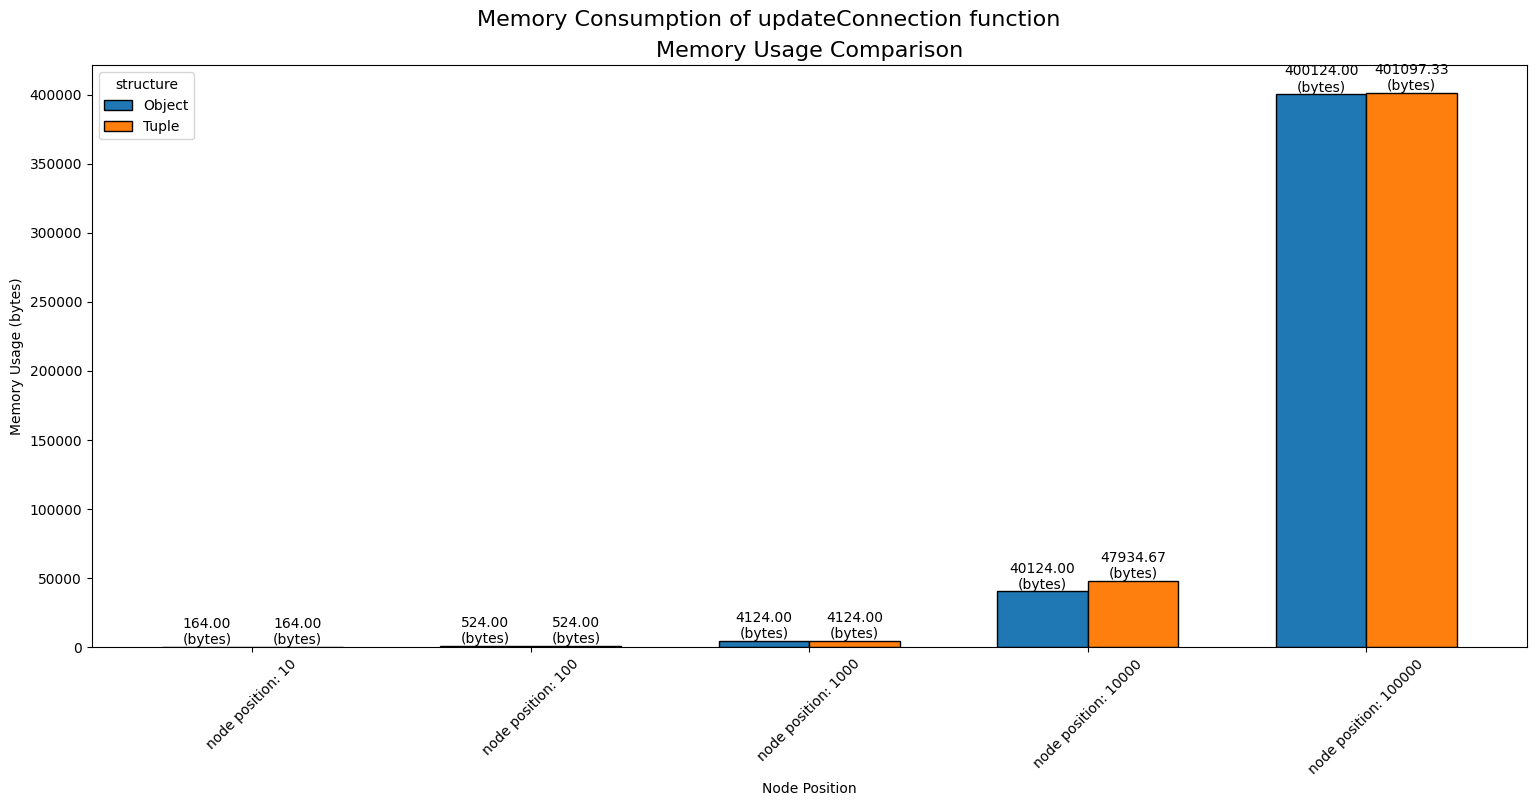

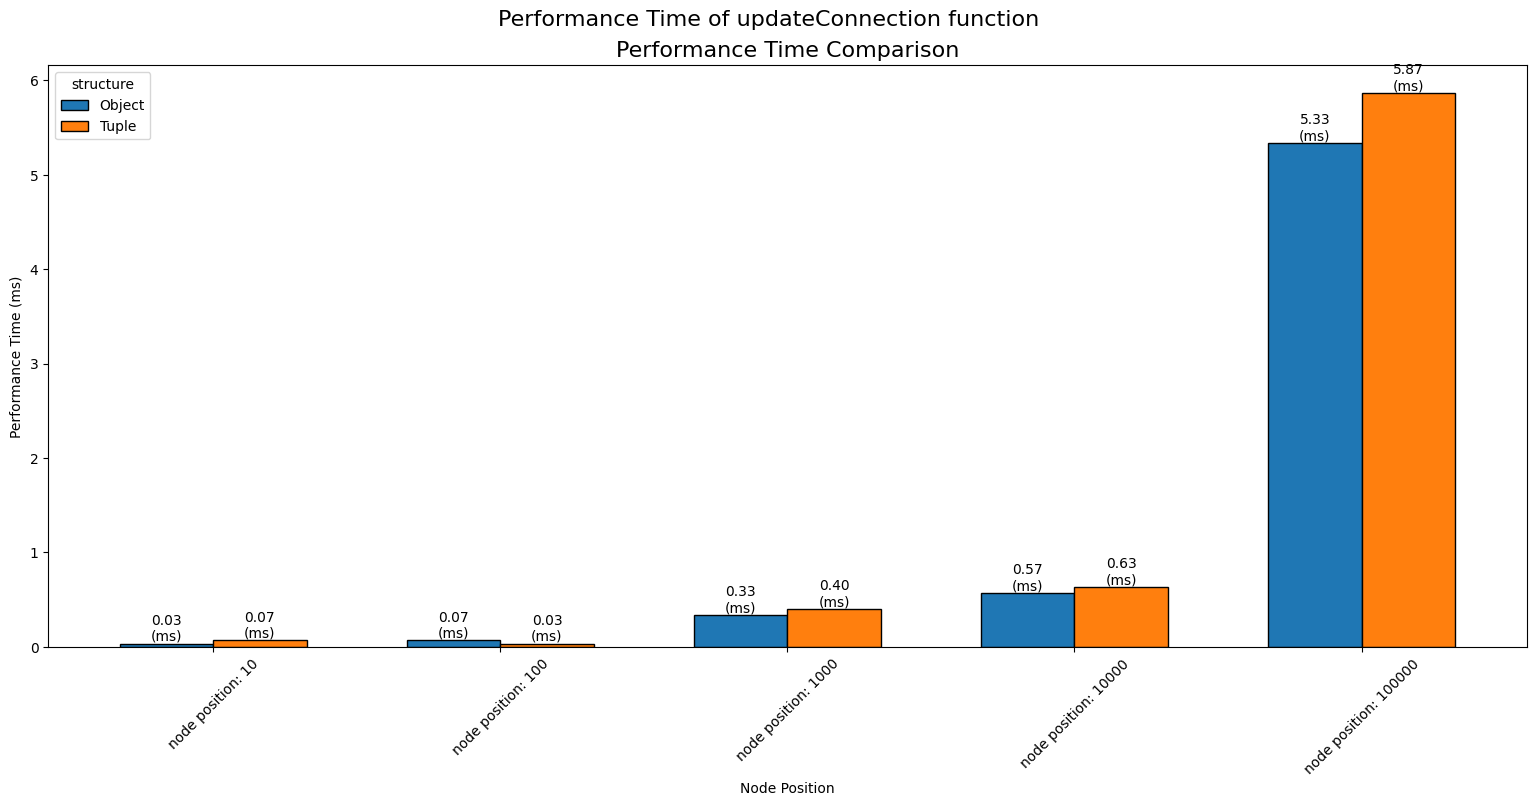

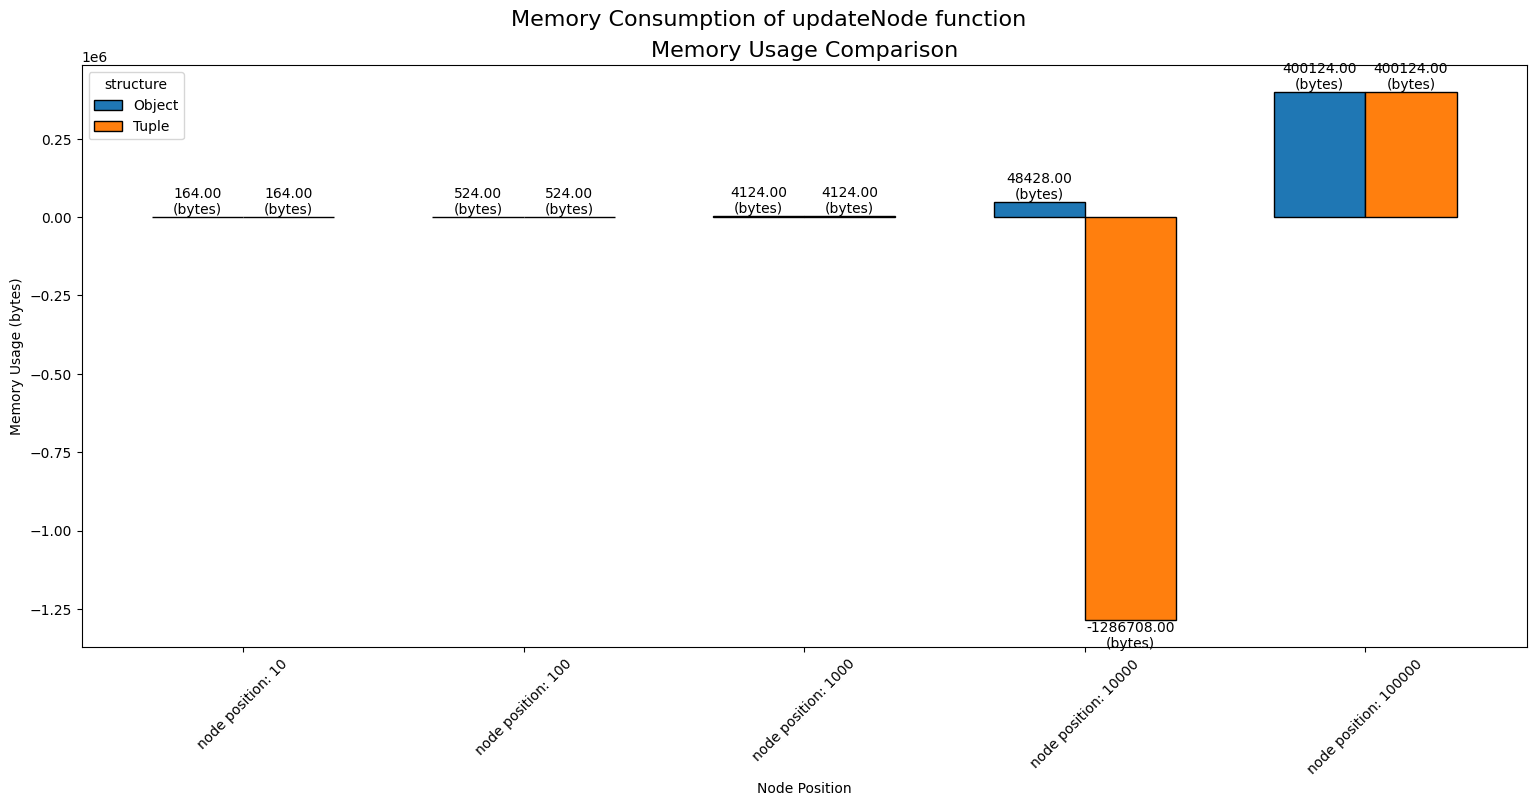

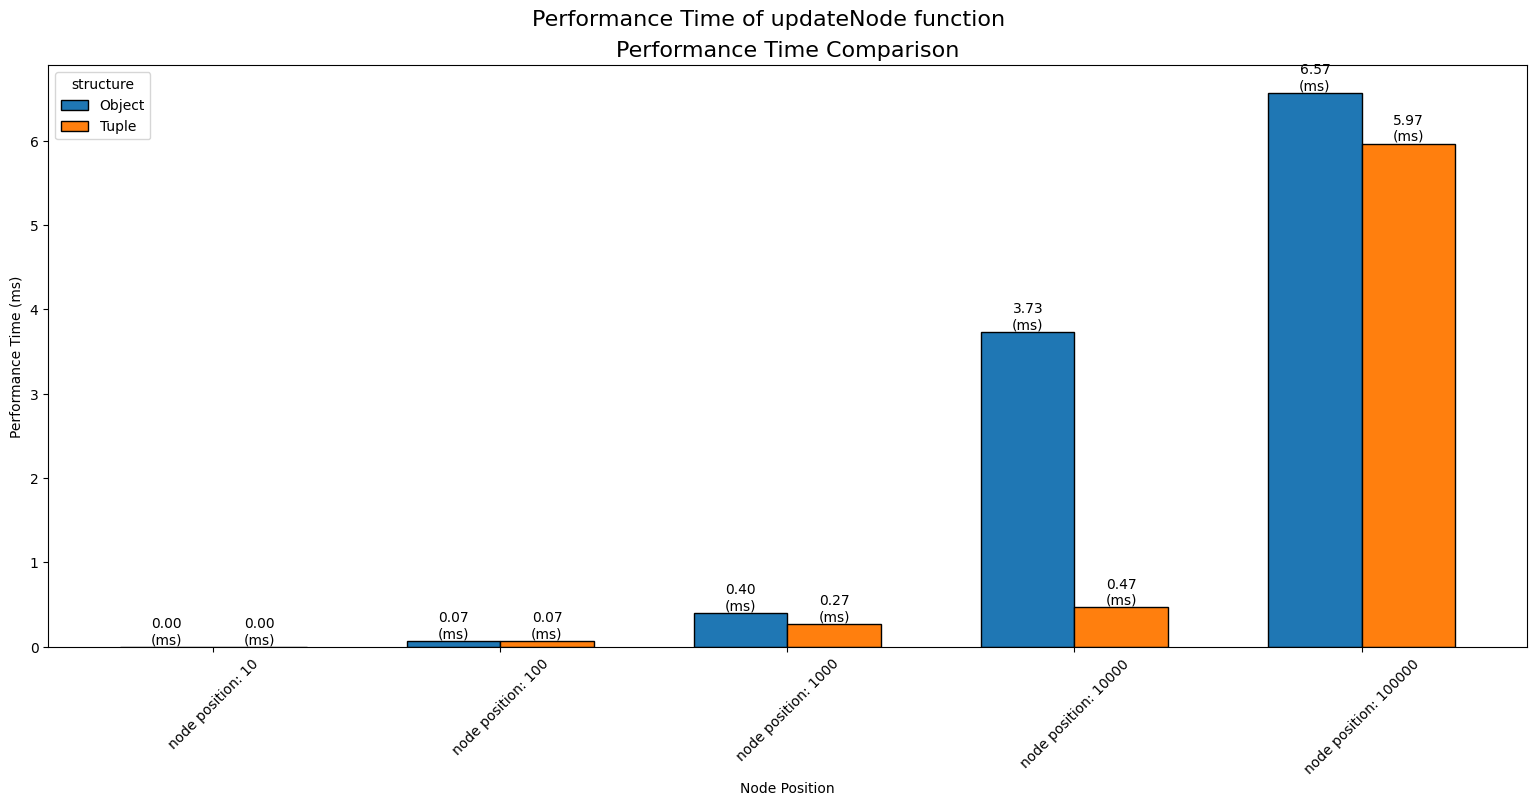

In [1]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to process each data file
def process_data(file_path):
    with open(file_path) as f:
        data = json.load(f)

    performance_rows = []
    memory_rows = []

    for entry in data:
        measurement = entry['measurement']
        
        if 'performance' in measurement:
            structure = measurement['performance']['structure']
            action = measurement['performance']['action']
            qty_or_after = measurement['performance'].get('qty', measurement['performance'].get('after'))
            metric_type = 'qty' if 'qty' in measurement['performance'] else 'after'
            time = measurement['performance']['time']
            performance_rows.append([structure, action, metric_type, qty_or_after, time])
        
        if 'memory' in measurement:
            structure = measurement['memory']['structure']
            action = measurement['memory']['action']
            qty_or_after = measurement['memory'].get('qty', measurement['memory'].get('after'))
            metric_type = 'qty' if 'qty' in measurement['memory'] else 'after'
            size = measurement['memory']['size']
            memory_rows.append([structure, action, metric_type, qty_or_after, size])

    performance_df = pd.DataFrame(performance_rows, columns=['structure', 'action', 'metric_type', 'metric_value', 'time'])
    memory_df = pd.DataFrame(memory_rows, columns=['structure', 'action', 'metric_type', 'metric_value', 'size'])
    
    return performance_df, memory_df

# Process all files
performance_dfs = []
memory_dfs = []

# Assuming there are multiple files benchmark.report.1.json, benchmark.report.2.json, benchmark.report.3.json
for i in range(1, 4):
    file_path = f"../output/specReports/benchmark.report.{i}.json"    
    perf_df, mem_df = process_data(file_path) 
    performance_dfs.append(perf_df)
    memory_dfs.append(mem_df)

# Concatenate dataframes
all_performance_df = pd.concat(performance_dfs)
all_memory_df = pd.concat(memory_dfs)

# Group by necessary columns and calculate the mean
performance_df = all_performance_df.groupby(['structure', 'action', 'metric_type', 'metric_value'], as_index=False).mean()
memory_df = all_memory_df.groupby(['structure', 'action', 'metric_type', 'metric_value'], as_index=False).mean()

# Merging performance and memory data
merged_df = pd.merge(performance_df, memory_df, on=['structure', 'action', 'metric_type', 'metric_value'], suffixes=('_time', '_memory'))

# Combine metric type and value for unique x-axis labels
merged_df['metric'] = merged_df['metric_type'] + ': ' + merged_df['metric_value'].astype(str)

# Find the largest values to adjust bar width
max_memory = merged_df['size'].max()
max_time = merged_df['time'].max()

# Set a consistent bar width scaling factor
bar_width_scaling_factor = 0.65

# Make output directory if it doesn't exist
if not os.path.exists('../output/plots'):
    os.makedirs('../output/plots')

# Plotting the separate graphs
def plot_individual_graphs(df, action):
    subset = df[df['action'] == action]

    # Determine X-axis label
    x_label = 'Node Position' if len(subset['metric'].unique()) > 1 else 'Node Count'
    
    fig_memory, ax_memory = plt.subplots(figsize=(16, 9))
    memory_subset = subset.pivot(index='metric', columns='structure', values='size')
    memory_subset = memory_subset.rename(lambda x: x.replace('after', 'node position') if len(subset['metric'].unique()) > 1 else x.replace('after', 'node count'))
    memory_subset.plot(kind='bar', ax=ax_memory, width=bar_width_scaling_factor, edgecolor='black')
    ax_memory.set_title('Memory Usage Comparison', fontsize=16)
    ax_memory.set_xlabel(x_label)
    ax_memory.set_ylabel('Memory Usage (bytes)')
    ax_memory.legend(title='structure', loc='upper left')
    ax_memory.tick_params(axis='x', labelrotation=45)

    # Annotate memory bars with their values
    for container in ax_memory.containers:
        ax_memory.bar_label(container, fmt='%.2f\n(bytes)', label_type='edge')

    fig_memory.suptitle(f'Memory Consumption of {action} function', y=0.92, fontsize=16)
    fig_memory.tight_layout(pad=3)
    plt.show()

    fig_memory.savefig(f'../output/plots/{action}_memory_comparison.png', bbox_inches='tight')

    fig_time, ax_time = plt.subplots(figsize=(16, 9))
    time_subset = subset.pivot(index='metric', columns='structure', values='time')
    time_subset = time_subset.rename(lambda x: x.replace('after', 'node position') if len(subset['metric'].unique()) > 1 else x.replace('after', 'node count'))
    time_subset.plot(kind='bar', ax=ax_time, width=bar_width_scaling_factor, edgecolor='black')
    ax_time.set_title('Performance Time Comparison', fontsize=16)
    ax_time.set_xlabel(x_label)
    ax_time.set_ylabel('Performance Time (ms)')
    ax_time.legend(title='structure', loc='upper left')
    ax_time.tick_params(axis='x', labelrotation=45)

    # Annotate time bars with their values
    for container in ax_time.containers:
        ax_time.bar_label(container, fmt='%.2f\n(ms)', label_type='edge')

    fig_time.suptitle(f'Performance Time of {action} function', y=0.92, fontsize=16)
    fig_time.tight_layout(pad=3)
    plt.show()

    fig_time.savefig(f'../output/plots/{action}_time_comparison.png', bbox_inches='tight')

keys = [
    "addConnection",
    "addConnections",
    "addNode",
    "addNodes",
    "addNodeMetadata",
    "updateNodeMetadata",
    "findConnectionById",
    "findNodeById",
    "removeConnectionById",
    "removeNodeById",
    "translateConnection",
    "translateNode",
    "updateConnection",
    "updateNode"
]

# Plot individual bar charts for each action
for action in sorted(merged_df['action'].unique(), key=lambda x: keys.index(x)):
    plot_individual_graphs(merged_df, action)
